## Phân tích Khách hàng Sâu
#### **Mục tiêu (Objectives)**

- Phân tích hành vi mua sắm của khách hàng
- Xây dựng customer segmentation (Phân khúc khách hàng)
- Thực hiện RFM Analysis (Phân tích RFM)
- Phát hiện customer lifetime value patterns (Mẫu giá trị trọn đời khách hàng)

## 1. Import và setup

In [1]:
# Import các thư viện cần thiết
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from dotenv import load_dotenv
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)      # Hiển thị tất cả cột
pd.set_option('display.width', None)            # Không giới hạn chiều rộng
pd.set_option('display.max_colwidth', None)     # Không giới hạn độ rộng cột

# Load biến môi trường từ file .env
load_dotenv()

# Lấy thông tin kết nối database
DB_USER = os.getenv("DB_USER")
DB_PASS = os.getenv("DB_PASS")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_GOLD = os.getenv("DB_GOLD")

# Tạo kết nối tới Gold database
gold_engine = create_engine(f"mysql+pymysql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_GOLD}")


## 2. Load data 

In [2]:
# Load du lieu tat ca cac bang

df_orders = pd.read_sql_table("fact_orders", gold_engine)
df_orders_items = pd.read_sql_table("fact_order_items", gold_engine)
df_products = pd.read_sql_table("dim_products", gold_engine)
df_customers = pd.read_sql_table("dim_customers", gold_engine)
df_date = pd.read_sql_table("dim_date", gold_engine)
df_pages = pd.read_sql_table("dim_order_pages", gold_engine)
df_payments = pd.read_sql_table("dim_order_payments", gold_engine)
df_shipping = pd.read_sql_table("dim_order_shipping", gold_engine)
df_warehouses = pd.read_sql_table("dim_order_warehouses", gold_engine)
df_shop = pd.read_sql_table("dim_shop", gold_engine) 

## Nội dung phân tích (Analysis Content)

### A. RFM Analysis (Recency, Frequency, Monetary)
RFM là phương pháp phân tích khách hàng dựa trên 3 yếu tố:
- R (Recency): Thời gian gần đây nhất khách hàng mua hàng
- F (Frequency): Tần suất mua hàng của khách hàng
- M (Monetary): Giá trị tiền tệ khách hàng đã chi tiêu

In [3]:
# Tính toán RFM cho từng khách hàng
df_orders['date_id'] = df_orders['date_id'].astype(int)
def calculate_rfm_metrics():
    
    # Lấy dữ liệu cần thiết
    rfm_data = df_orders.merge(df_customers, on='customer_id', how='inner')
    rfm_data = rfm_data.merge(df_date, left_on='date_id', right_on='date_id', how='inner')
    
    # Tính toán RFM
    rfm_table = rfm_data.groupby('customer_id').agg({
        'full_date': 'max',                    # Recency: Ngày mua cuối cùng
        'order_id': 'count',                   # Frequency: Số lần mua
        'total_price': 'sum'                   # Monetary: Tổng giá trị mua
    }).reset_index()
    
    # Đổi tên cột
    rfm_table.columns = ['customer_id', 'last_order_date', 'frequency', 'monetary']
    
    # Tính Recency (số ngày từ lần mua cuối)
    current_date = rfm_table['last_order_date'].max()
    rfm_table['recency'] = (current_date - rfm_table['last_order_date']).dt.days
    
    # Thêm thông tin khách hàng
    rfm_table = rfm_table.merge(
        df_customers[['customer_id', 'name', 'gender', 'phone']], 
        on='customer_id', 
        how='left'
    )
    
    print(f"Hoàn thành! Phân tích {len(rfm_table)} khách hàng")
    return rfm_table

# Chạy tính toán RFM
rfm_table = calculate_rfm_metrics()
print(f"\nRFM Table Shape: {rfm_table.shape}")

Hoàn thành! Phân tích 36080 khách hàng

RFM Table Shape: (36080, 8)


In [4]:
# Hệ thống chấm điểm RFM (1-5 scale)
def calculate_rfm_scores(rfm_table):
    
    # Recency Score (càng gần đây càng cao điểm)
    def recency_score(days):
        if days <= 30:      return 5  # Rất gần đây
        elif days <= 90:    return 4  # Gần đây  
        elif days <= 180:   return 3  # Trung bình
        elif days <= 365:   return 2  # Xa
        else:               return 1  # Rất xa
    
    # Frequency Score (càng nhiều lần càng cao điểm)
    def frequency_score(count):
        if count >= 10:     return 5  # Rất thường xuyên
        elif count >= 5:    return 4  # Thường xuyên
        elif count >= 3:    return 3  # Trung bình
        elif count >= 2:    return 2  # Ít
        else:               return 1  # Rất ít
    
    # Monetary Score (càng chi nhiều càng cao điểm)
    def monetary_score(amount):
        if amount >= 1000000:    return 5  # VIP
        elif amount >= 500000:  return 4  # Cao
        elif amount >= 300000:  return 3  # Trung bình
        elif amount >= 100000:   return 2  # Thấp
        else:                    return 1  # Rất thấp
    
    # Áp dụng scoring
    rfm_table['recency_score'] = rfm_table['recency'].apply(recency_score)
    rfm_table['frequency_score'] = rfm_table['frequency'].apply(frequency_score)
    rfm_table['monetary_score'] = rfm_table['monetary'].apply(monetary_score)
    
    # Tạo RFM segment
    rfm_table['rfm_segment'] = (
        rfm_table['recency_score'].astype(str) + 
        rfm_table['frequency_score'].astype(str) + 
        rfm_table['monetary_score'].astype(str)
    )
    return rfm_table

# Tính RFM scores
rfm_table = calculate_rfm_scores(rfm_table)
rfm_table.head(2)


,customer_id,last_order_date,frequency,monetary,recency,name,gender,phone,recency_score,frequency_score,monetary_score,rfm_segment
0,000030f6-43c2-41ec-b84c-940bff8016f3,2024-11-26,1,649000.0,263,Son Anh,Nam,0886569099,2,1,4,214
1,0000db9e-55c4-462c-bbdc-bd16659fa47f,2024-04-29,1,538000.0,474,Đinh Nghị,Nữ,0367324375,1,1,4,114


### B. Customer Segmentation

In [5]:
def create_customer_segments(rfm_table):
    def assign_segment(row):
        r, f, m = row['recency_score'], row['frequency_score'], row['monetary_score']

        # 1. Khách hàng Chiến Thắng (Champions - R, F, M cao nhất)
        if r >= 4 and f >= 4 and m >= 4:
            return 'Khách hàng Chiến Thắng (VIP)'

        # 2. Không Thể Mất (Cannot Lose Them - F, M cao, R khá)
        # Ưu tiên đặt trước Khách hàng trung thành vì đây là nhóm có giá trị cao cần giữ lại.
        elif r >= 3 and f >= 4 and m >= 4:
            return 'Nhóm Cần Phải Giữ (Giá trị cao)'

        # 3. Khách hàng Trung Thành (Loyal Customers - R, F, M khá cao)
        elif r >= 3 and f >= 3 and m >= 3:
            return 'Khách hàng Trung Thành'

        # 4. Khách hàng Tiềm Năng (Potential Loyalists - R cao, F trung bình, M khá)
        # Có xu hướng mua gần đây, giá trị tốt, cần khuyến khích mua thường xuyên hơn.
        elif r >= 3 and f >= 2 and m >= 3:
            return 'Khách hàng Tiềm Năng'
        
        # 5. Khách hàng Mới (New Customers - R cao, F, M thấp)
        # Mới mua gần đây, cần nuôi dưỡng để thành Khách hàng Tiềm Năng.
        elif r >= 4 and f <= 2 and m <= 2:
            return 'Khách hàng Mới'
        
        # 6. Khách hàng Có Nguy Cơ Bỏ Đi (At Risk - R thấp, F, M cao)
        # Từng mua nhiều và giá trị cao nhưng đã lâu không mua lại, cần tái kích hoạt ngay.
        elif r <= 2 and f >= 2 and m >= 2:
            return 'Khách hàng Nguy Cơ Bỏ Đi'
        
        # 7. Khách hàng Ngủ Đông (Hibernating - R, F thấp, M trung bình/cao)
        # Đã lâu không mua, nhưng từng chi tiêu khá, cần ưu đãi đặc biệt để đánh thức.
        elif r <= 2 and f <= 2 and m >= 2:
            return 'Khách hàng Ngủ Đông'
        
        # 8. Khách hàng Đã Mất (Lost - R, F, M thấp)
        # Đã rất lâu không mua, tần suất/giá trị thấp, cần ưu tiên thấp nhất.
        elif r <= 2 and f <= 2 and m <= 2:
            return 'Khách hàng Đã Mất'
        
        # 9. Các trường hợp còn lại
        else:
            return 'Khách hàng Phát Sinh Khác'

    rfm_table['customer_segment'] = rfm_table.apply(assign_segment, axis=1)
    return rfm_table

# Ví dụ sử dụng:
rfm_table = create_customer_segments(rfm_table)

In [6]:
rfm_table.head(2)

,customer_id,last_order_date,frequency,monetary,recency,name,gender,phone,recency_score,frequency_score,monetary_score,rfm_segment,customer_segment
0,000030f6-43c2-41ec-b84c-940bff8016f3,2024-11-26,1,649000.0,263,Son Anh,Nam,0886569099,2,1,4,214,Khách hàng Ngủ Đông
1,0000db9e-55c4-462c-bbdc-bd16659fa47f,2024-04-29,1,538000.0,474,Đinh Nghị,Nữ,0367324375,1,1,4,114,Khách hàng Ngủ Đông


In [7]:
# Tổng quan RFM
print(f"   Tổng số khách hàng: {len(rfm_table):,}")
print(f"   Recency trung bình: {rfm_table['recency'].mean():.1f} ngày")
print(f"   Frequency trung bình: {rfm_table['frequency'].mean():.1f} lần")
print(f"   Monetary trung bình: {rfm_table['monetary'].mean():,.0f} VND")
print('-'*60)

# Top customers by segment
segment_counts = rfm_table['customer_segment'].value_counts()
for segment, count in segment_counts.head().items():
    percentage = (count / len(rfm_table)) * 100
    print(f"   {segment}: {count:,} khách hàng ({percentage:.1f}%)")
print('-'*60)

# Revenue by segment
segment_revenue = rfm_table.groupby('customer_segment')['monetary'].sum().sort_values(ascending=False)
for segment, revenue in segment_revenue.head().items():
    print(f"   {segment}: {revenue:,.0f} VND")
print('-'*60)

# Top customers
top_customers = rfm_table.nlargest(10, 'monetary')[['name', 'gender', 'frequency', 'monetary', 'customer_segment']]
for idx, row in top_customers.iterrows():
    print(f"   {row['name']} ({row['gender']}): {row['monetary']:,.0f} VND, {row['frequency']} orders - {row['customer_segment']}")

   Tổng số khách hàng: 36,080
   Recency trung bình: 367.7 ngày
   Frequency trung bình: 1.1 lần
   Monetary trung bình: 495,540 VND
------------------------------------------------------------
   Khách hàng Ngủ Đông: 28,390 khách hàng (78.7%)
   Khách hàng Đã Mất: 3,454 khách hàng (9.6%)
   Khách hàng Nguy Cơ Bỏ Đi: 3,024 khách hàng (8.4%)
   Khách hàng Phát Sinh Khác: 893 khách hàng (2.5%)
   Khách hàng Tiềm Năng: 167 khách hàng (0.5%)
------------------------------------------------------------
   Khách hàng Ngủ Đông: 14,347,639,900 VND
   Khách hàng Nguy Cơ Bỏ Đi: 2,837,294,000 VND
   Khách hàng Phát Sinh Khác: 448,935,000 VND
   Khách hàng Tiềm Năng: 161,509,000 VND
   Khách hàng Trung Thành: 66,283,000 VND
------------------------------------------------------------
   Diệp Tràm (Nữ): 18,053,000 VND, 5 orders - Khách hàng Nguy Cơ Bỏ Đi
   An To (Nam): 7,070,000 VND, 2 orders - Khách hàng Nguy Cơ Bỏ Đi
   Thái Tâm (Nam): 5,742,000 VND, 3 orders - Khách hàng Nguy Cơ Bỏ Đi
   Mai Xu

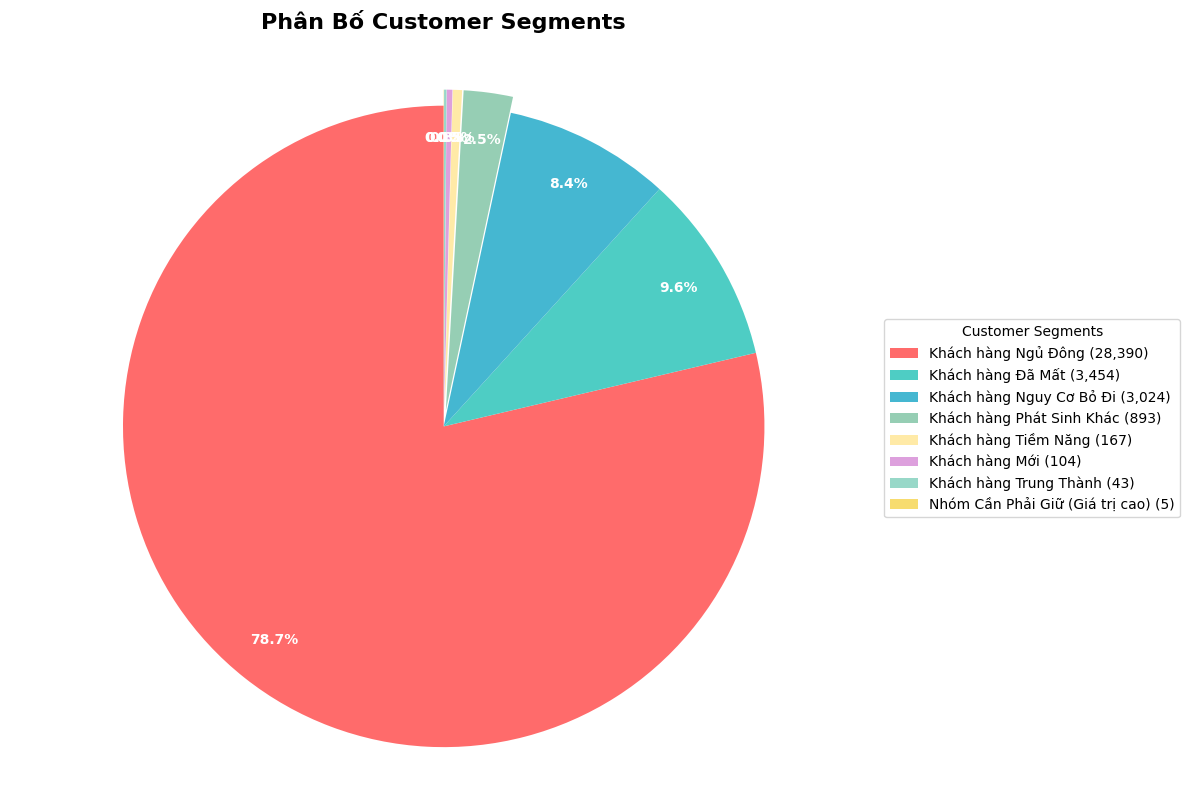

In [8]:
# Tạo biểu đồ tròn với layout tối ưu để tránh chồng chéo
plt.figure(figsize=(12, 8))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD', '#98D8C8', '#F7DC6F']

# Tạo explode cho các segment nhỏ để tách biệt
explode = [0.05 if count < 1000 else 0 for count in segment_counts.values]

# Sử dụng segment_counts đã tính sẵn
wedges, texts, autotexts = plt.pie(segment_counts.values, 
                                  labels=None,  # Bỏ labels để tránh chồng chéo
                                  autopct='%1.1f%%', 
                                  colors=colors, 
                                  startangle=90,
                                  explode=explode,
                                  pctdistance=0.85)

# Tùy chỉnh text
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(10)

# Tạo legend bên ngoài biểu đồ để tránh chồng chéo
plt.legend(wedges, [f'{label} ({count:,})' for label, count in segment_counts.items()],
           title="Customer Segments",
           loc="center left",
           bbox_to_anchor=(1, 0, 0.5, 1),
           fontsize=10)

plt.title('Phân Bố Customer Segments', 
          fontsize=16, fontweight='bold', pad=20)
plt.axis('equal')
plt.tight_layout()
plt.show()

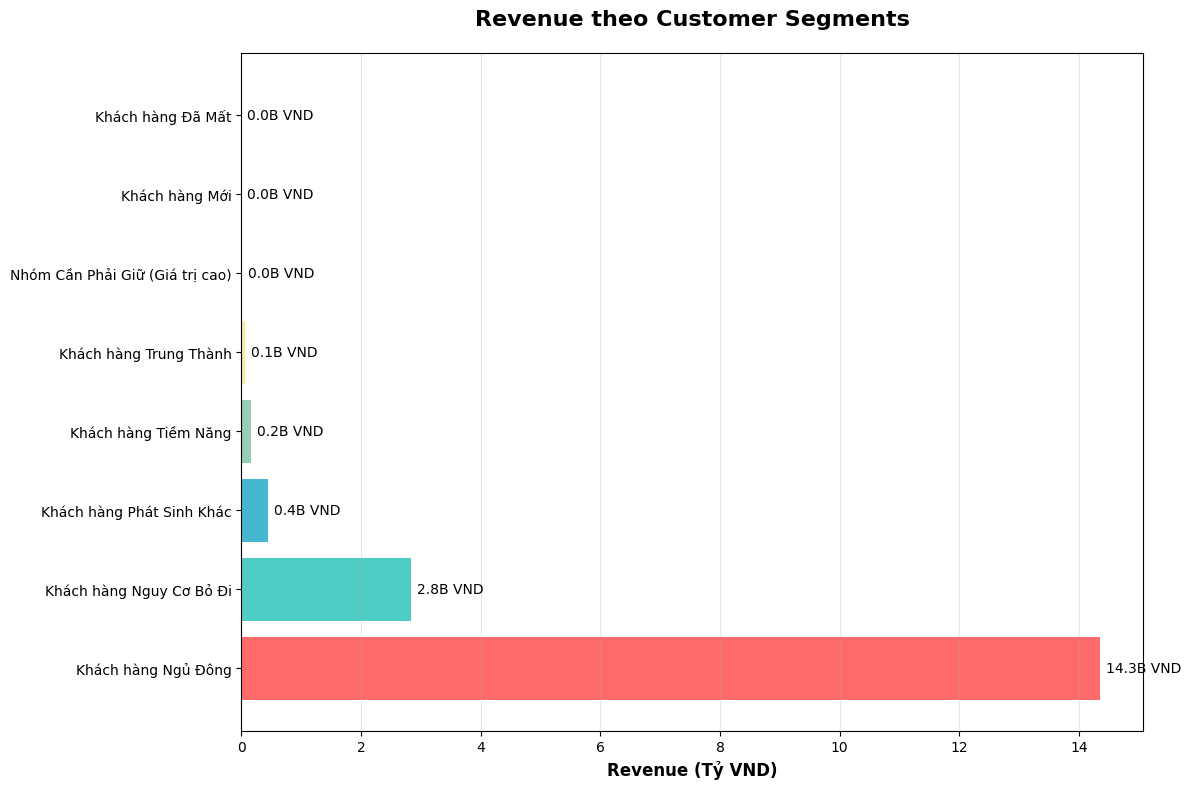

In [9]:
# Sử dụng dữ liệu thực tế từ segment_revenue
plt.figure(figsize=(12, 8))

# Sử dụng segment_revenue đã tính sẵn
segments = segment_revenue.index
revenues = segment_revenue.values

# Chuyển đổi sang tỷ VND
revenues_billions = revenues / 1000000000

# Tạo horizontal bar chart
bars = plt.barh(segments, revenues_billions, color=colors)

# Thêm giá trị trên mỗi bar
for i, (bar, revenue) in enumerate(zip(bars, revenues_billions)):
    plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
             f'{revenue:.1f}B VND', va='center')

plt.xlabel('Revenue (Tỷ VND)', fontsize=12, fontweight='bold')
plt.title('Revenue theo Customer Segments', fontsize=16, fontweight='bold', pad=20)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

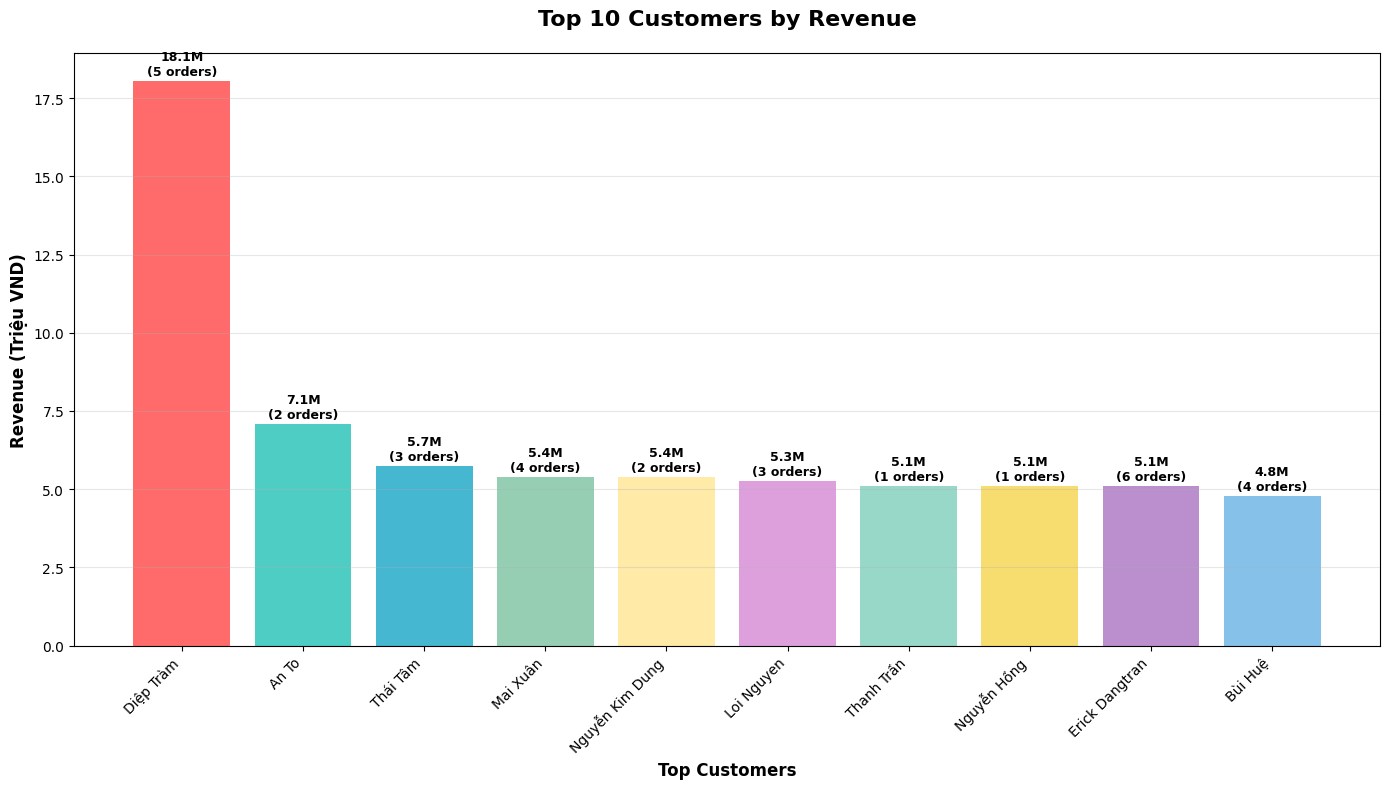

In [10]:
# Sử dụng dữ liệu thực tế từ top_customers
plt.figure(figsize=(14, 8))

# Lấy dữ liệu từ top_customers
top_customers_data = rfm_table.nlargest(10, 'monetary')
names = top_customers_data['name'].tolist()
revenues = top_customers_data['monetary'].tolist()
orders = top_customers_data['frequency'].tolist()

# Chuyển đổi sang triệu VND
revenues_millions = [r/1000000 for r in revenues]

bars = plt.bar(range(len(names)), revenues_millions, 
               color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7',
                      '#DDA0DD', '#98D8C8', '#F7DC6F', '#BB8FCE', '#85C1E9'])

# Thêm giá trị trên mỗi bar
for i, (bar, revenue, order) in enumerate(zip(bars, revenues_millions, orders)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{revenue:.1f}M\n({order} orders)', ha='center', va='bottom', 
             fontweight='bold', fontsize=9)

plt.xlabel('Top Customers', fontsize=12, fontweight='bold')
plt.ylabel('Revenue (Triệu VND)', fontsize=12, fontweight='bold')
plt.title('Top 10 Customers by Revenue', fontsize=16, fontweight='bold', pad=20)
plt.xticks(range(len(names)), names, rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

<Figure size 1500x600 with 0 Axes>

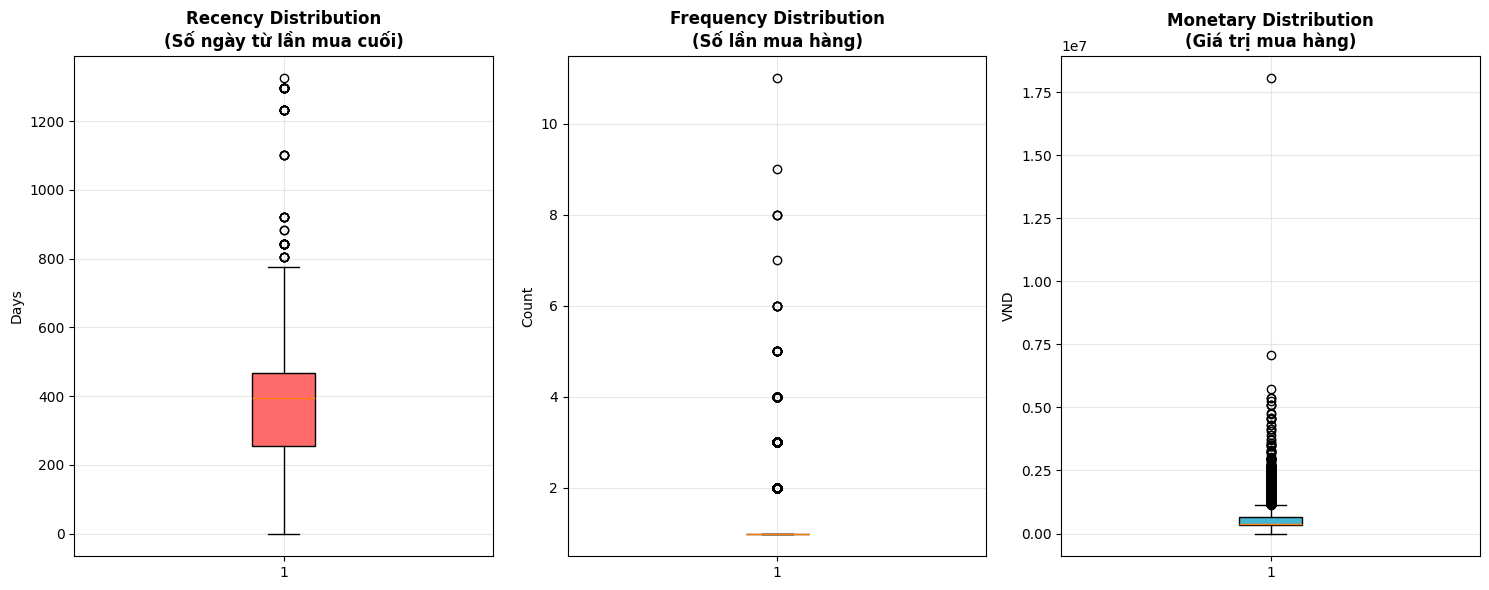

In [11]:
# Sử dụng dữ liệu thực tế từ rfm_table
plt.figure(figsize=(15, 6))

# Tạo subplot cho từng metric
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

# Recency
axes[0].boxplot(rfm_table['recency'], patch_artist=True, boxprops=dict(facecolor='#FF6B6B'))
axes[0].set_title('Recency Distribution\n(Số ngày từ lần mua cuối)', fontweight='bold')
axes[0].set_ylabel('Days')
axes[0].grid(True, alpha=0.3)

# Frequency  
axes[1].boxplot(rfm_table['frequency'], patch_artist=True, boxprops=dict(facecolor='#4ECDC4'))
axes[1].set_title('Frequency Distribution\n(Số lần mua hàng)', fontweight='bold')
axes[1].set_ylabel('Count')
axes[1].grid(True, alpha=0.3)

# Monetary
axes[2].boxplot(rfm_table['monetary'], patch_artist=True, boxprops=dict(facecolor='#45B7D1'))
axes[2].set_title('Monetary Distribution\n(Giá trị mua hàng)', fontweight='bold')
axes[2].set_ylabel('VND')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### C. Customer Lifetime Value (CLV)

### D. Behavioral Analysis (Phân tích hành vi)

#### 1. Mẫu Mua Hàng (Purchase Patterns)

##### 1.1. Ngày bán chạy nhất trong tuần

In [12]:
# Phân tích ngày bán chạy nhất trong tuần
def analyze_best_selling_days():
    # Merge orders với date dimension
    orders_with_date = df_orders.merge(df_date, on='date_id', how='inner')
    
    # Tính toán metrics theo ngày trong tuần
    daily_metrics = orders_with_date.groupby(['day_of_week', 'weekday_name']).agg({
        'order_id': 'count',                    # Số đơn hàng
        'total_price': 'sum',                   # Tổng doanh thu
        'total_quantity': 'sum',                # Tổng số lượng sản phẩm
        'customer_id': 'nunique'               # Số khách hàng unique
    }).reset_index()
    
    # Đổi tên cột
    daily_metrics.columns = ['day_of_week', 'weekday_name', 'total_orders', 'total_revenue', 'total_quantity', 'unique_customers']
    
    # Tính AOV (Average Order Value) cho mỗi ngày
    daily_metrics['avg_order_value'] = daily_metrics['total_revenue'] / daily_metrics['total_orders']
    
    # Tính số lượng sản phẩm trung bình mỗi đơn hàng
    daily_metrics['avg_quantity_per_order'] = daily_metrics['total_quantity'] / daily_metrics['total_orders']
    
    # Sắp xếp theo thứ tự ngày trong tuần
    daily_metrics = daily_metrics.sort_values('day_of_week')
    
    return daily_metrics

# Chạy phân tích
daily_sales_analysis = analyze_best_selling_days()
print("=== PHÂN TÍCH NGÀY BÁN CHẠY NHẤT TRONG TUẦN ===")
print(f"Phân tích dựa trên {len(df_orders):,} đơn hàng")
print("-" * 60)
daily_sales_analysis

=== PHÂN TÍCH NGÀY BÁN CHẠY NHẤT TRONG TUẦN ===
Phân tích dựa trên 40,236 đơn hàng
------------------------------------------------------------


,day_of_week,weekday_name,total_orders,total_revenue,total_quantity,unique_customers,avg_order_value,avg_quantity_per_order
0,0,Thứ Hai,5697,2.503859e+09,6701,5485,439504.827102,1.176233
1,1,Thứ Ba,5918,2.605749e+09,6736,5705,440309.057114,1.138222
2,2,Thứ Tư,6082,2.728143e+09,6978,5886,448560.177573,1.147320
3,3,Thứ Năm,5934,2.702756e+09,6810,5709,455469.497809,1.147624
4,4,Thứ Sáu,5649,2.526927e+09,6551,5459,447322.889007,1.159674
5,5,Thứ Bảy,5374,2.377632e+09,6289,5209,442432.433941,1.170264
6,6,Chủ Nhật,5582,2.434012e+09,6573,5402,436046.578287,1.177535


In [13]:
# Hiển thị kết quả chi tiết
print("=== RANKING NGÀY BÁN CHẠY NHẤT THEO CÁC CHỈ SỐ ===")
print()

# 1. Ranking theo số đơn hàng
print("TOP NGÀY THEO SỐ ĐƠN HÀNG:")
top_orders = daily_sales_analysis.nlargest(7, 'total_orders')[['weekday_name', 'total_orders', 'total_revenue']]
for idx, row in top_orders.iterrows():
    print(f"   {row['weekday_name']}: {row['total_orders']:,} đơn hàng ({row['total_revenue']:,.0f} VND)")

print()

# 2. Ranking theo doanh thu
print("TOP NGÀY THEO DOANH THU:")
top_revenue = daily_sales_analysis.nlargest(7, 'total_revenue')[['weekday_name', 'total_revenue', 'total_orders']]
for idx, row in top_revenue.iterrows():
    print(f"   {row['weekday_name']}: {row['total_revenue']:,.0f} VND ({row['total_orders']:,} đơn hàng)")

print()

# 3. Ranking theo số lượng sản phẩm
print("TOP NGÀY THEO SỐ LƯỢNG SẢN PHẨM:")
top_quantity = daily_sales_analysis.nlargest(7, 'total_quantity')[['weekday_name', 'total_quantity', 'total_orders']]
for idx, row in top_quantity.iterrows():
    print(f"   {row['weekday_name']}: {row['total_quantity']:,} sản phẩm ({row['total_orders']:,} đơn hàng)")

print()

# 4. Ranking theo AOV
print("TOP NGÀY THEO GIÁ TRỊ ĐƠN HÀNG TRUNG BÌNH:")
top_aov = daily_sales_analysis.nlargest(7, 'avg_order_value')[['weekday_name', 'avg_order_value', 'total_orders']]
for idx, row in top_aov.iterrows():
    print(f"   {row['weekday_name']}: {row['avg_order_value']:,.0f} VND/đơn ({row['total_orders']:,} đơn hàng)")

=== RANKING NGÀY BÁN CHẠY NHẤT THEO CÁC CHỈ SỐ ===

TOP NGÀY THEO SỐ ĐƠN HÀNG:
   Thứ Tư: 6,082 đơn hàng (2,728,143,000 VND)
   Thứ Năm: 5,934 đơn hàng (2,702,756,000 VND)
   Thứ Ba: 5,918 đơn hàng (2,605,749,000 VND)
   Thứ Hai: 5,697 đơn hàng (2,503,859,000 VND)
   Thứ Sáu: 5,649 đơn hàng (2,526,927,000 VND)
   Chủ Nhật: 5,582 đơn hàng (2,434,012,000 VND)
   Thứ Bảy: 5,374 đơn hàng (2,377,631,900 VND)

TOP NGÀY THEO DOANH THU:
   Thứ Tư: 2,728,143,000 VND (6,082 đơn hàng)
   Thứ Năm: 2,702,756,000 VND (5,934 đơn hàng)
   Thứ Ba: 2,605,749,000 VND (5,918 đơn hàng)
   Thứ Sáu: 2,526,927,000 VND (5,649 đơn hàng)
   Thứ Hai: 2,503,859,000 VND (5,697 đơn hàng)
   Chủ Nhật: 2,434,012,000 VND (5,582 đơn hàng)
   Thứ Bảy: 2,377,631,900 VND (5,374 đơn hàng)

TOP NGÀY THEO SỐ LƯỢNG SẢN PHẨM:
   Thứ Tư: 6,978 sản phẩm (6,082 đơn hàng)
   Thứ Năm: 6,810 sản phẩm (5,934 đơn hàng)
   Thứ Ba: 6,736 sản phẩm (5,918 đơn hàng)
   Thứ Hai: 6,701 sản phẩm (5,697 đơn hàng)
   Chủ Nhật: 6,573 sản phẩm (5,

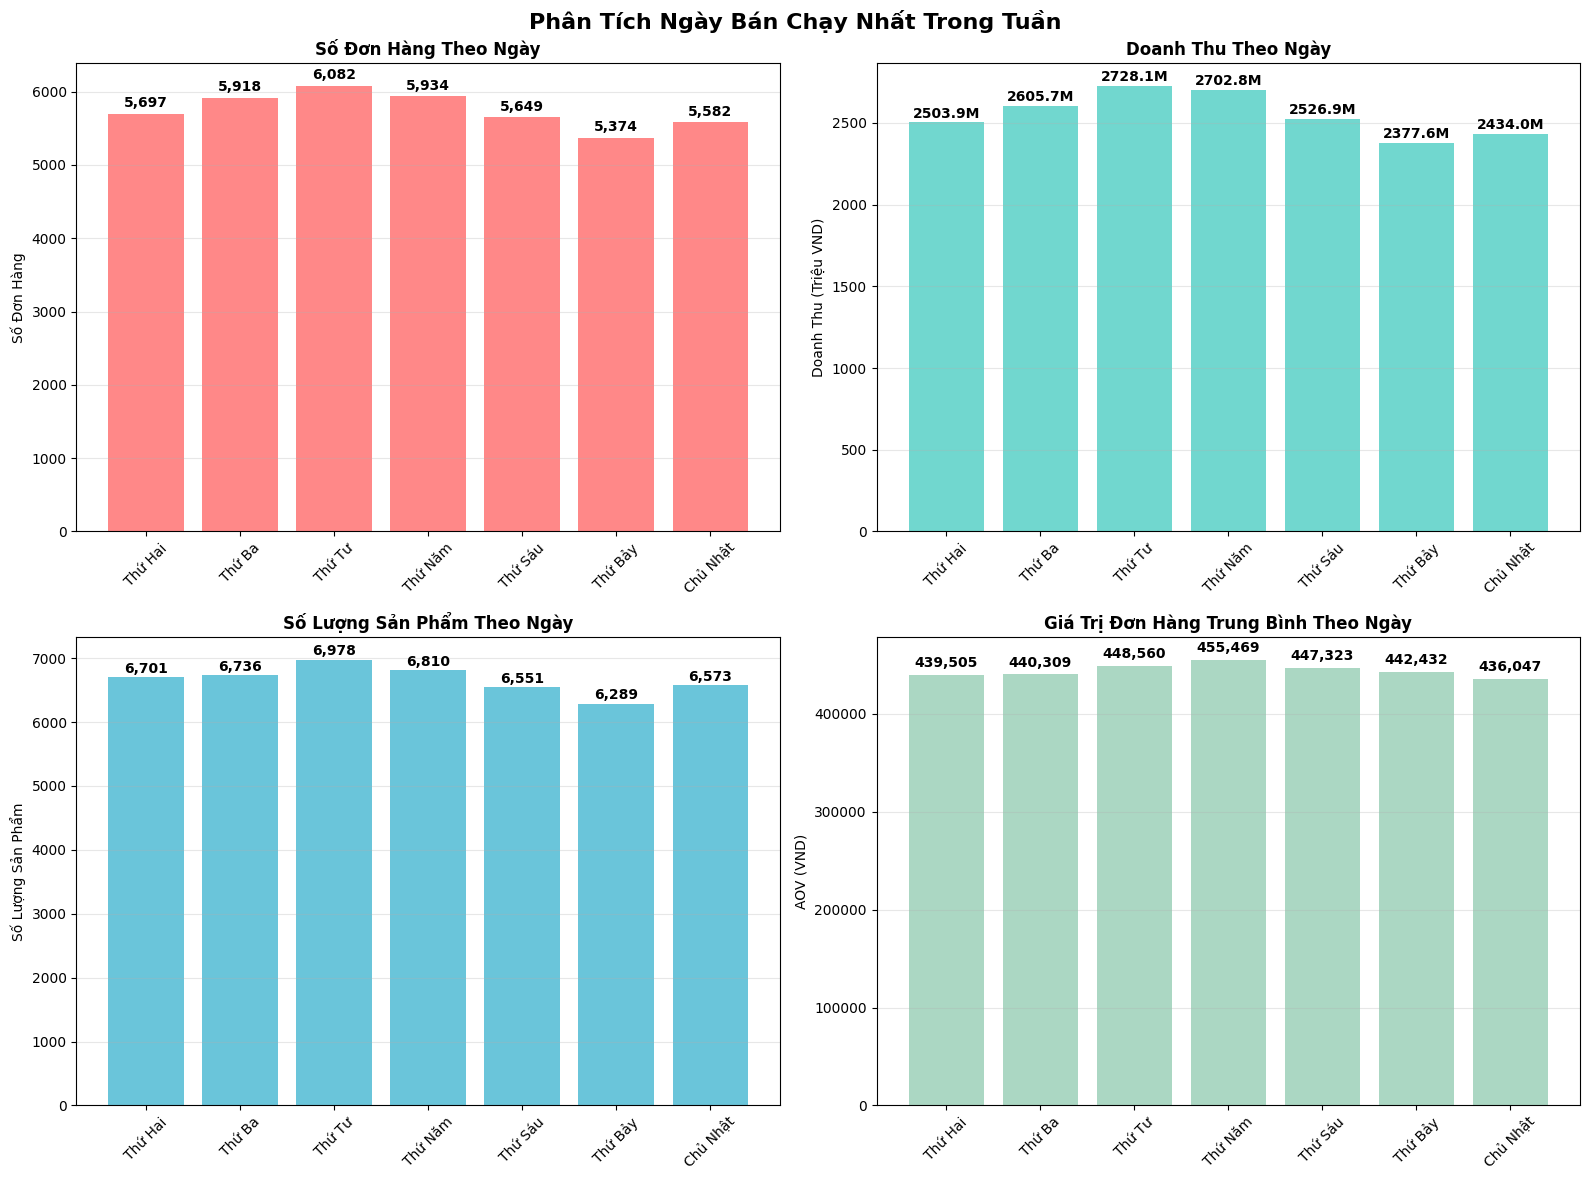

In [14]:
# Tạo biểu đồ so sánh các ngày trong tuần
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Phân Tích Ngày Bán Chạy Nhất Trong Tuần', fontsize=16, fontweight='bold', y=0.98)

# 1. Số đơn hàng theo ngày
axes[0,0].bar(daily_sales_analysis['weekday_name'], daily_sales_analysis['total_orders'], 
              color='#FF6B6B', alpha=0.8)
axes[0,0].set_title('Số Đơn Hàng Theo Ngày', fontweight='bold')
axes[0,0].set_ylabel('Số Đơn Hàng')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(axis='y', alpha=0.3)

# Thêm giá trị trên mỗi bar
for i, v in enumerate(daily_sales_analysis['total_orders']):
    axes[0,0].text(i, v + 50, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# 2. Doanh thu theo ngày
axes[0,1].bar(daily_sales_analysis['weekday_name'], daily_sales_analysis['total_revenue']/1000000, 
              color='#4ECDC4', alpha=0.8)
axes[0,1].set_title('Doanh Thu Theo Ngày', fontweight='bold')
axes[0,1].set_ylabel('Doanh Thu (Triệu VND)')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(axis='y', alpha=0.3)

# Thêm giá trị trên mỗi bar
for i, v in enumerate(daily_sales_analysis['total_revenue']/1000000):
    axes[0,1].text(i, v + 10, f'{v:.1f}M', ha='center', va='bottom', fontweight='bold')

# 3. Số lượng sản phẩm theo ngày
axes[1,0].bar(daily_sales_analysis['weekday_name'], daily_sales_analysis['total_quantity'], 
              color='#45B7D1', alpha=0.8)
axes[1,0].set_title('Số Lượng Sản Phẩm Theo Ngày', fontweight='bold')
axes[1,0].set_ylabel('Số Lượng Sản Phẩm')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(axis='y', alpha=0.3)

# Thêm giá trị trên mỗi bar
for i, v in enumerate(daily_sales_analysis['total_quantity']):
    axes[1,0].text(i, v + 20, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# 4. AOV theo ngày
axes[1,1].bar(daily_sales_analysis['weekday_name'], daily_sales_analysis['avg_order_value'], 
              color='#96CEB4', alpha=0.8)
axes[1,1].set_title('Giá Trị Đơn Hàng Trung Bình Theo Ngày', fontweight='bold')
axes[1,1].set_ylabel('AOV (VND)')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(axis='y', alpha=0.3)

# Thêm giá trị trên mỗi bar
for i, v in enumerate(daily_sales_analysis['avg_order_value']):
    axes[1,1].text(i, v + 5000, f'{v:,.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

##### 1.2. Giờ mua sắm cao điểm

In [15]:
# Phân tích giờ mua sắm cao điểm
def analyze_peak_shopping_hours():
    """
    Phân tích giờ mua sắm cao điểm dựa trên:
    - Số lượng đơn hàng theo giờ
    - Tổng doanh thu theo giờ  
    - Số lượng sản phẩm bán được theo giờ
    - Số khách hàng unique theo giờ
    """
    
    # Tạo bản sao để không ảnh hưởng dữ liệu gốc
    orders_analysis = df_orders.copy()
    
    # Chuyển đổi inserted_at thành datetime và extract hour
    orders_analysis['order_datetime'] = pd.to_datetime(orders_analysis['inserted_at'])
    orders_analysis['order_hour'] = orders_analysis['order_datetime'].dt.hour
    orders_analysis['order_date'] = orders_analysis['order_datetime'].dt.date
    
    # Tính toán metrics theo giờ
    hourly_metrics = orders_analysis.groupby('order_hour').agg({
        'order_id': 'count',                    # Số đơn hàng
        'total_price': 'sum',                   # Tổng doanh thu
        'total_quantity': 'sum',                # Tổng số lượng sản phẩm
        'customer_id': 'nunique'                # Số khách hàng unique
    }).reset_index()
    
    # Đổi tên cột
    hourly_metrics.columns = ['hour', 'total_orders', 'total_revenue', 'total_quantity', 'unique_customers']
    
    # Tính AOV (Average Order Value) cho mỗi giờ
    hourly_metrics['avg_order_value'] = hourly_metrics['total_revenue'] / hourly_metrics['total_orders']
    
    # Tính số lượng sản phẩm trung bình mỗi đơn hàng
    hourly_metrics['avg_quantity_per_order'] = hourly_metrics['total_quantity'] / hourly_metrics['total_orders']
    
    # Thêm thông tin thời gian
    hourly_metrics['time_period'] = hourly_metrics['hour'].apply(lambda x: 
        'Sáng sớm (6-11h)' if 6 <= x < 12 else
        'Trưa (12-17h)' if 12 <= x < 18 else  
        'Tối (18-23h)' if 18 <= x < 24 else
        'Đêm (0-5h)'
    )
    
    # Sắp xếp theo giờ
    hourly_metrics = hourly_metrics.sort_values('hour')
    
    return hourly_metrics, orders_analysis

# Chạy phân tích
hourly_sales_analysis, orders_with_hour = analyze_peak_shopping_hours()
print("=== PHÂN TÍCH GIỜ MUA SẮM CAO ĐIỂM ===")
print(f"Phân tích dựa trên {len(df_orders):,} đơn hàng")
print(f"Thời gian từ {orders_with_hour['order_datetime'].min()} đến {orders_with_hour['order_datetime'].max()}")
print("-" * 60)
hourly_sales_analysis

=== PHÂN TÍCH GIỜ MUA SẮM CAO ĐIỂM ===
Phân tích dựa trên 40,236 đơn hàng
Thời gian từ 2021-12-30 03:13:15 đến 2025-08-16 02:19:59
------------------------------------------------------------


,hour,total_orders,total_revenue,total_quantity,unique_customers,avg_order_value,avg_quantity_per_order,time_period
0,0,2093,9.288200e+08,2479,2054,443774.486383,1.184424,Đêm (0-5h)
1,1,2536,1.132337e+09,2965,2470,446505.126183,1.169164,Đêm (0-5h)
2,2,2846,1.293699e+09,3355,2783,454567.463106,1.178848,Đêm (0-5h)
3,3,2784,1.266183e+09,3287,2701,454807.112069,1.180675,Đêm (0-5h)
4,4,2512,1.112476e+09,2872,2436,442864.649682,1.143312,Đêm (0-5h)
5,5,2304,9.620450e+08,2520,2256,417554.253472,1.093750,Đêm (0-5h)
6,6,2225,9.658360e+08,2582,2181,434083.595506,1.160449,Sáng sớm (6-11h)
7,7,2336,1.022731e+09,2704,2272,437812.928082,1.157534,Sáng sớm (6-11h)
8,8,2384,1.057949e+09,2767,2307,443770.553691,1.160654,Sáng sớm (6-11h)
9,9,2149,9.560130e+08,2476,2105,444864.122848,1.152164,Sáng sớm (6-11h)


In [16]:
# Hiển thị kết quả chi tiết
print("=== RANKING GIỜ MUA SẮM CAO ĐIỂM THEO CÁC CHỈ SỐ ===")
print()

# 1. Ranking theo số đơn hàng
print("TOP GIỜ THEO SỐ ĐƠN HÀNG:")
top_orders_hour = hourly_sales_analysis.nlargest(10, 'total_orders')[['hour', 'total_orders', 'total_revenue', 'time_period']]
for idx, row in top_orders_hour.iterrows():
    print(f"   {row['hour']:02d}:00 - {row['hour']+1:02d}:00 ({row['time_period']}): {row['total_orders']:,} đơn hàng ({row['total_revenue']:,.0f} VND)")

print()

# 2. Ranking theo doanh thu
print("TOP GIỜ THEO DOANH THU:")
top_revenue_hour = hourly_sales_analysis.nlargest(10, 'total_revenue')[['hour', 'total_revenue', 'total_orders', 'time_period']]
for idx, row in top_revenue_hour.iterrows():
    print(f"   {row['hour']:02d}:00 - {row['hour']+1:02d}:00 ({row['time_period']}): {row['total_revenue']:,.0f} VND ({row['total_orders']:,} đơn hàng)")

print()

# 3. Ranking theo số lượng sản phẩm
print("TOP GIỜ THEO SỐ LƯỢNG SẢN PHẨM:")
top_quantity_hour = hourly_sales_analysis.nlargest(10, 'total_quantity')[['hour', 'total_quantity', 'total_orders', 'time_period']]
for idx, row in top_quantity_hour.iterrows():
    print(f"   {row['hour']:02d}:00 - {row['hour']+1:02d}:00 ({row['time_period']}): {row['total_quantity']:,} sản phẩm ({row['total_orders']:,} đơn hàng)")

print()

# 4. Ranking theo AOV
print("TOP GIỜ THEO GIÁ TRỊ ĐƠN HÀNG TRUNG BÌNH:")
top_aov_hour = hourly_sales_analysis.nlargest(10, 'avg_order_value')[['hour', 'avg_order_value', 'total_orders', 'time_period']]
for idx, row in top_aov_hour.iterrows():
    print(f"   {row['hour']:02d}:00 - {row['hour']+1:02d}:00 ({row['time_period']}): {row['avg_order_value']:,.0f} VND/đơn ({row['total_orders']:,} đơn hàng)")

=== RANKING GIỜ MUA SẮM CAO ĐIỂM THEO CÁC CHỈ SỐ ===

TOP GIỜ THEO SỐ ĐƠN HÀNG:
   02:00 - 03:00 (Đêm (0-5h)): 2,846 đơn hàng (1,293,699,000 VND)
   03:00 - 04:00 (Đêm (0-5h)): 2,784 đơn hàng (1,266,183,000 VND)
   01:00 - 02:00 (Đêm (0-5h)): 2,536 đơn hàng (1,132,337,000 VND)
   04:00 - 05:00 (Đêm (0-5h)): 2,512 đơn hàng (1,112,476,000 VND)
   13:00 - 14:00 (Trưa (12-17h)): 2,465 đơn hàng (1,117,163,000 VND)
   14:00 - 15:00 (Trưa (12-17h)): 2,436 đơn hàng (1,093,761,000 VND)
   08:00 - 09:00 (Sáng sớm (6-11h)): 2,384 đơn hàng (1,057,949,000 VND)
   07:00 - 08:00 (Sáng sớm (6-11h)): 2,336 đơn hàng (1,022,731,000 VND)
   12:00 - 13:00 (Trưa (12-17h)): 2,317 đơn hàng (1,026,931,000 VND)
   05:00 - 06:00 (Đêm (0-5h)): 2,304 đơn hàng (962,045,000 VND)

TOP GIỜ THEO DOANH THU:
   02:00 - 03:00 (Đêm (0-5h)): 1,293,699,000 VND (2,846 đơn hàng)
   03:00 - 04:00 (Đêm (0-5h)): 1,266,183,000 VND (2,784 đơn hàng)
   01:00 - 02:00 (Đêm (0-5h)): 1,132,337,000 VND (2,536 đơn hàng)
   13:00 - 14:00 (

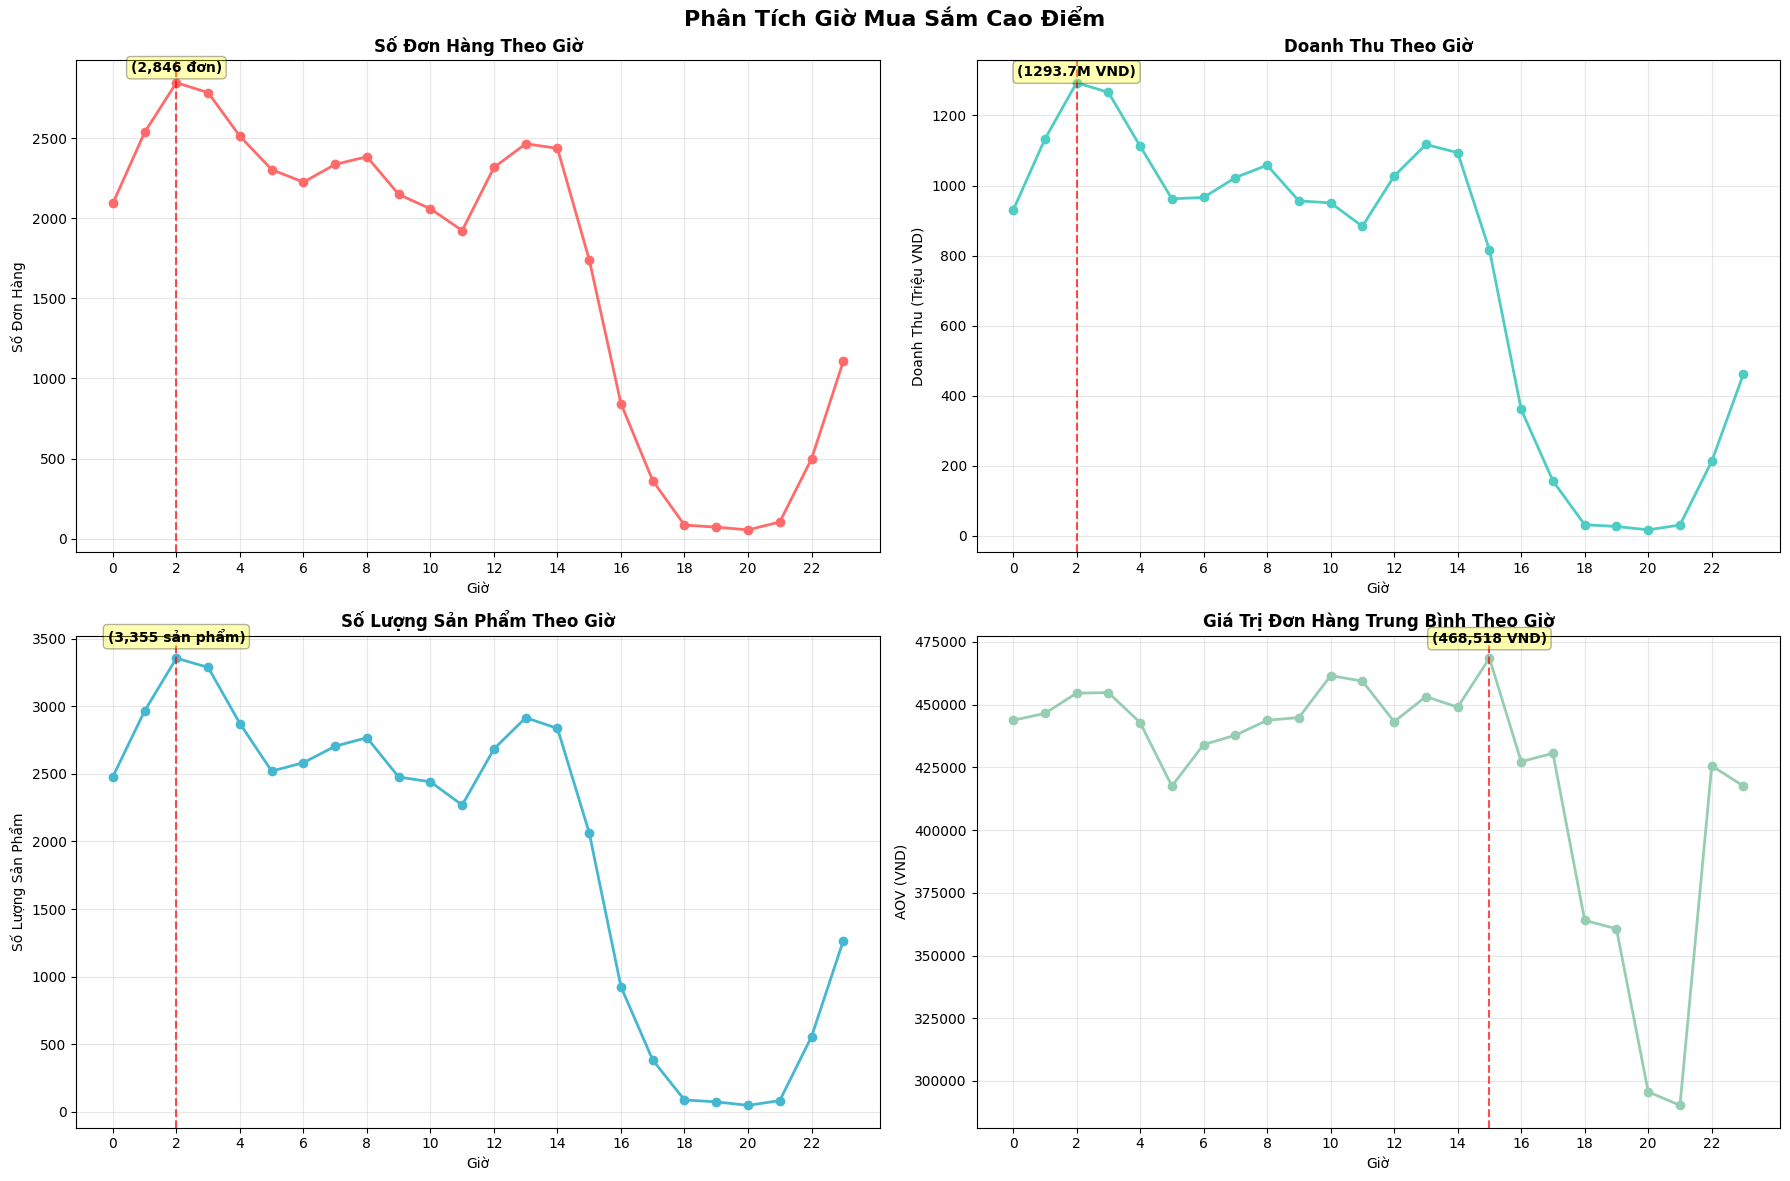

In [17]:
# Tạo biểu đồ phân tích giờ mua sắm
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Phân Tích Giờ Mua Sắm Cao Điểm', fontsize=16, fontweight='bold', y=0.98)

# 1. Số đơn hàng theo giờ
axes[0,0].plot(hourly_sales_analysis['hour'], hourly_sales_analysis['total_orders'], 
               marker='o', linewidth=2, markersize=6, color='#FF6B6B')
axes[0,0].set_title('Số Đơn Hàng Theo Giờ', fontweight='bold')
axes[0,0].set_xlabel('Giờ')
axes[0,0].set_ylabel('Số Đơn Hàng')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].set_xticks(range(0, 24, 2))

# Highlight peak hours
peak_orders = hourly_sales_analysis.loc[hourly_sales_analysis['total_orders'].idxmax()]
axes[0,0].axvline(x=peak_orders['hour'], color='red', linestyle='--', alpha=0.7)
axes[0,0].text(peak_orders['hour'], peak_orders['total_orders'] + 50, 
              f'({peak_orders["total_orders"]:,} đơn)', 
              ha='center', va='bottom', fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.3))

# 2. Doanh thu theo giờ
axes[0,1].plot(hourly_sales_analysis['hour'], hourly_sales_analysis['total_revenue']/1000000, 
               marker='o', linewidth=2, markersize=6, color='#4ECDC4')
axes[0,1].set_title('Doanh Thu Theo Giờ', fontweight='bold')
axes[0,1].set_xlabel('Giờ')
axes[0,1].set_ylabel('Doanh Thu (Triệu VND)')
axes[0,1].grid(True, alpha=0.3)
axes[0,1].set_xticks(range(0, 24, 2))

# Highlight peak revenue hours
peak_revenue = hourly_sales_analysis.loc[hourly_sales_analysis['total_revenue'].idxmax()]
axes[0,1].axvline(x=peak_revenue['hour'], color='red', linestyle='--', alpha=0.7)
axes[0,1].text(peak_revenue['hour'], peak_revenue['total_revenue']/1000000 + 10, 
               f'({peak_revenue["total_revenue"]/1000000:.1f}M VND)', 
               ha='center', va='bottom', fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.3))

# 3. Số lượng sản phẩm theo giờ
axes[1,0].plot(hourly_sales_analysis['hour'], hourly_sales_analysis['total_quantity'], 
               marker='o', linewidth=2, markersize=6, color='#45B7D1')
axes[1,0].set_title('Số Lượng Sản Phẩm Theo Giờ', fontweight='bold')
axes[1,0].set_xlabel('Giờ')
axes[1,0].set_ylabel('Số Lượng Sản Phẩm')
axes[1,0].grid(True, alpha=0.3)
axes[1,0].set_xticks(range(0, 24, 2))

# Highlight peak quantity hours
peak_quantity = hourly_sales_analysis.loc[hourly_sales_analysis['total_quantity'].idxmax()]
axes[1,0].axvline(x=peak_quantity['hour'], color='red', linestyle='--', alpha=0.7)
axes[1,0].text(peak_quantity['hour'], peak_quantity['total_quantity'] + 100, 
               f'({peak_quantity["total_quantity"]:,} sản phẩm)', 
               ha='center', va='bottom', fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.3))

# 4. AOV theo giờ
axes[1,1].plot(hourly_sales_analysis['hour'], hourly_sales_analysis['avg_order_value'], 
               marker='o', linewidth=2, markersize=6, color='#96CEB4')
axes[1,1].set_title('Giá Trị Đơn Hàng Trung Bình Theo Giờ', fontweight='bold')
axes[1,1].set_xlabel('Giờ')
axes[1,1].set_ylabel('AOV (VND)')
axes[1,1].grid(True, alpha=0.3)
axes[1,1].set_xticks(range(0, 24, 2))

# Highlight peak AOV hours
peak_aov = hourly_sales_analysis.loc[hourly_sales_analysis['avg_order_value'].idxmax()]
axes[1,1].axvline(x=peak_aov['hour'], color='red', linestyle='--', alpha=0.7)
axes[1,1].text(peak_aov['hour'], peak_aov['avg_order_value'] + 5000, 
               f'({peak_aov["avg_order_value"]:,.0f} VND)', 
               ha='center', va='bottom', fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.3))

plt.tight_layout()
plt.show()

##### 1.3. Hành vi mua theo mùa

In [18]:
# Phân tích hành vi mua theo mùa
def analyze_seasonal_behavior():
    # Merge orders với date dimension
    orders_with_season = df_orders.merge(df_date, on='date_id', how='inner')
    
    # Tạo cột season từ tháng
    def get_season(month):
        if month in [12, 1, 2]: return 'Đông'
        elif month in [3, 4, 5]: return 'Xuân'
        elif month in [6, 7, 8]: return 'Hè'
        else: return 'Thu'
    
    orders_with_season['season'] = orders_with_season['month'].apply(get_season)
    
    # Phân tích theo mùa
    seasonal_analysis = orders_with_season.groupby('season').agg({
        'order_id': 'count',
        'total_price': 'sum',
        'total_quantity': 'sum',
        'customer_id': 'nunique'
    }).reset_index()
    
    seasonal_analysis.columns = ['season', 'total_orders', 'total_revenue', 'total_quantity', 'unique_customers']
    seasonal_analysis['avg_order_value'] = seasonal_analysis['total_revenue'] / seasonal_analysis['total_orders']
    
    return seasonal_analysis

# Chạy phân tích
seasonal_analysis = analyze_seasonal_behavior()
print("=== HÀNH VI MUA THEO MÙA ===")
seasonal_analysis

=== HÀNH VI MUA THEO MÙA ===


,season,total_orders,total_revenue,total_quantity,unique_customers,avg_order_value
0,Hè,11420,4.431955e+09,13132,10533,388087.127846
1,Thu,6897,3.528730e+09,7853,6370,511632.593881
2,Xuân,9436,3.552859e+09,11467,8528,376521.725307
3,Đông,12483,6.365534e+09,14186,11487,509936.225266


In [19]:
# Hiển thị kết quả
print("=== RANKING MÙA BÁN CHẠY ===")
print()

# Ranking theo số đơn hàng
print("TOP MÙA THEO SỐ ĐƠN HÀNG:")
top_seasons = seasonal_analysis.nlargest(4, 'total_orders')
for idx, row in top_seasons.iterrows():
    print(f"   {row['season']}: {row['total_orders']:,} đơn hàng ({row['total_revenue']:,.0f} VND)")

print()

# Ranking theo doanh thu
print("TOP MÙA THEO DOANH THU:")
top_revenue_seasons = seasonal_analysis.nlargest(4, 'total_revenue')
for idx, row in top_revenue_seasons.iterrows():
    print(f"   {row['season']}: {row['total_revenue']:,.0f} VND ({row['total_orders']:,} đơn hàng)")

=== RANKING MÙA BÁN CHẠY ===

TOP MÙA THEO SỐ ĐƠN HÀNG:
   Đông: 12,483 đơn hàng (6,365,533,900 VND)
   Hè: 11,420 đơn hàng (4,431,955,000 VND)
   Xuân: 9,436 đơn hàng (3,552,859,000 VND)
   Thu: 6,897 đơn hàng (3,528,730,000 VND)

TOP MÙA THEO DOANH THU:
   Đông: 6,365,533,900 VND (12,483 đơn hàng)
   Hè: 4,431,955,000 VND (11,420 đơn hàng)
   Xuân: 3,552,859,000 VND (9,436 đơn hàng)
   Thu: 3,528,730,000 VND (6,897 đơn hàng)


<Figure size 1200x1000 with 0 Axes>

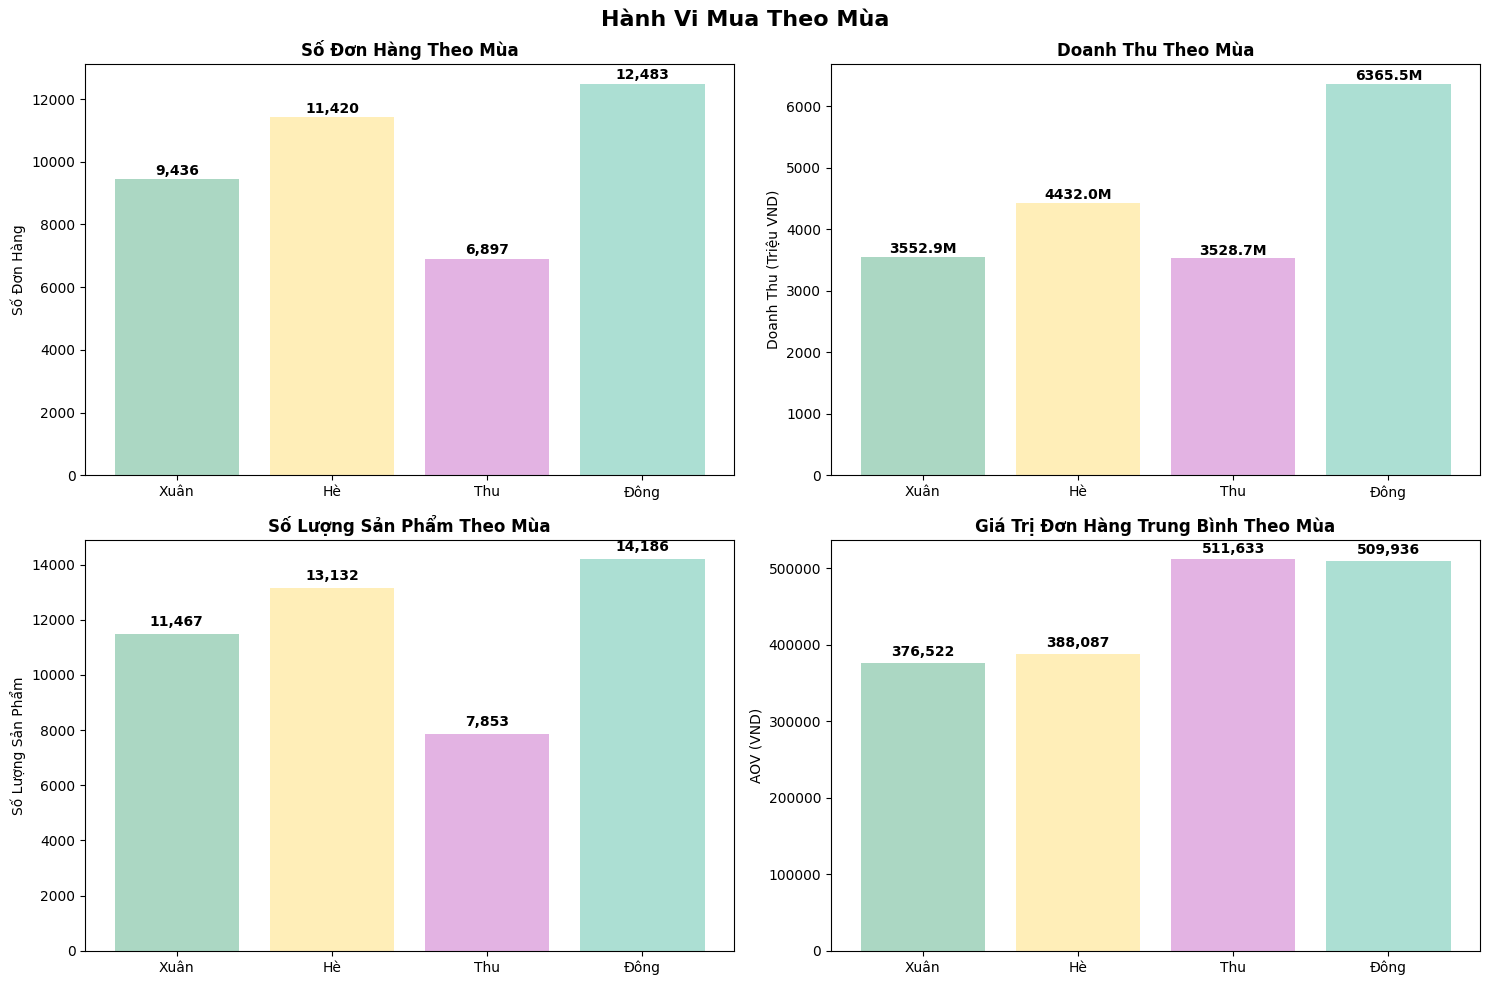

In [20]:
# Biểu đồ so sánh mùa
plt.figure(figsize=(12, 10))

# Sort theo thứ tự Xuân, Hè, Thu, Đông
season_order = ['Xuân', 'Hè', 'Thu', 'Đông']
seasonal_analysis_sorted = seasonal_analysis.set_index('season').reindex(season_order).reset_index()

# Tạo subplot 2x2
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Hành Vi Mua Theo Mùa', fontsize=16, fontweight='bold', y=0.98)

# 1. Số đơn hàng theo mùa
axes[0,0].bar(seasonal_analysis_sorted['season'], seasonal_analysis_sorted['total_orders'], 
              color=['#96CEB4', '#FFEAA7', '#DDA0DD', '#98D8C8'], alpha=0.8)
axes[0,0].set_title('Số Đơn Hàng Theo Mùa', fontweight='bold')
axes[0,0].set_ylabel('Số Đơn Hàng')
for i, v in enumerate(seasonal_analysis_sorted['total_orders']):
    axes[0,0].text(i, v + 50, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# 2. Doanh thu theo mùa
axes[0,1].bar(seasonal_analysis_sorted['season'], seasonal_analysis_sorted['total_revenue']/1000000, 
              color=['#96CEB4', '#FFEAA7', '#DDA0DD', '#98D8C8'], alpha=0.8)
axes[0,1].set_title('Doanh Thu Theo Mùa', fontweight='bold')
axes[0,1].set_ylabel('Doanh Thu (Triệu VND)')
for i, v in enumerate(seasonal_analysis_sorted['total_revenue']/1000000):
    axes[0,1].text(i, v + 10, f'{v:.1f}M', ha='center', va='bottom', fontweight='bold')

# 3. Số lượng sản phẩm theo mùa
axes[1,0].bar(seasonal_analysis_sorted['season'], seasonal_analysis_sorted['total_quantity'], 
              color=['#96CEB4', '#FFEAA7', '#DDA0DD', '#98D8C8'], alpha=0.8)
axes[1,0].set_title('Số Lượng Sản Phẩm Theo Mùa', fontweight='bold')
axes[1,0].set_ylabel('Số Lượng Sản Phẩm')
for i, v in enumerate(seasonal_analysis_sorted['total_quantity']):
    axes[1,0].text(i, v + 200, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# 4. AOV theo mùa
axes[1,1].bar(seasonal_analysis_sorted['season'], seasonal_analysis_sorted['avg_order_value'], 
              color=['#96CEB4', '#FFEAA7', '#DDA0DD', '#98D8C8'], alpha=0.8)
axes[1,1].set_title('Giá Trị Đơn Hàng Trung Bình Theo Mùa', fontweight='bold')
axes[1,1].set_ylabel('AOV (VND)')
for i, v in enumerate(seasonal_analysis_sorted['avg_order_value']):
    axes[1,1].text(i, v + 5000, f'{v:,.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

##### 1.4. Hành vi mua theo sản phẩm

In [21]:
# Merge các bảng để phân tích hành vi mua theo sản phẩm
def merge_product_analysis_tables():
    """
    Merge các bảng để có đầy đủ thông tin cho phân tích sản phẩm
    """
    
    # Merge fact_orders với fact_order_items
    orders_with_items = df_orders.merge(df_orders_items, on='order_id', how='inner')
    
    # Merge với dim_products
    orders_with_products = orders_with_items.merge(df_products, on='product_id', how='inner')
    
    # Merge với dim_customers
    orders_with_customers = orders_with_products.merge(df_customers, on='customer_id', how='inner')
    
    # Merge với dim_date
    orders_with_date = orders_with_customers.merge(df_date, on='date_id', how='inner')
    
    print(f"=== MERGE TABLES FOR PRODUCT ANALYSIS ===")
    print(f"Orders: {len(df_orders):,}")
    print(f"Order Items: {len(df_orders_items):,}")
    print(f"Products: {len(df_products):,}")
    print(f"Customers: {len(df_customers):,}")
    print(f"Final merged data: {len(orders_with_date):,} records")
    print("-" * 60)
    
    return orders_with_date

# Chạy merge
merged_data = merge_product_analysis_tables()
print("Merged data shape:", merged_data.shape)
print("Columns:", merged_data.columns.tolist())

=== MERGE TABLES FOR PRODUCT ANALYSIS ===
Orders: 40,236
Order Items: 46,611
Products: 37
Customers: 36,090
Final merged data: 44,534 records
------------------------------------------------------------
Merged data shape: (44534, 102)
Columns: ['order_id', 'system_id', 'shop_id_x', 'order_link', 'link_confirm_order', 'order_currency', 'total_price', 'total_price_after_sub_discount', 'total_discount', 'total_quantity_x', 'items_length', 'tax', 'shipping_fee', 'money_to_collect', 'is_free_shipping', 'customer_id', 'page_id', 'warehouse_id', 'shipping_id', 'payment_id', 'status', 'status_name', 'inserted_at_x', 'date_id', 'updated_at_x', 'order_item_id', 'product_id', 'variation_id', 'item_quantity', 'item_price', 'item_discount', 'return_quantity', 'returned_count', 'product_name', 'product_detail', 'name_x', 'custom_id', 'shop_id_y', 'type', 'category_name', 'creator_id', 'removed', 'lifecycle_days', 'min_price', 'max_price', 'total_variations', 'total_quantity_y', 'remain_quantity', 'c

In [22]:
merged_data.head(2)

,order_id,system_id,shop_id_x,order_link,link_confirm_order,order_currency,total_price,total_price_after_sub_discount,total_discount,total_quantity_x,items_length,tax,shipping_fee,money_to_collect,is_free_shipping,customer_id,page_id,warehouse_id,shipping_id,payment_id,status,status_name,inserted_at_x,date_id,updated_at_x,order_item_id,product_id,variation_id,item_quantity,item_price,item_discount,return_quantity,returned_count,product_name,product_detail,name_x,custom_id,shop_id_y,type,category_name,creator_id,removed,lifecycle_days,min_price,max_price,total_variations,total_quantity_y,remain_quantity,colors,sizes,inserted_at_y,updated_at_y,name_y,shop_id,gender,phone,order_count,succeed_order_count,returned_order_count,purchased_amount,last_order_at,inserted_at,updated_at,is_block,is_discount_by_level,active_levera_pay,reward_point,current_debts,count_referrals,referral_code,fb_id,order_sources,conversation_link,address_province_id,address_district_id,address_commune_id,address_full,full_date,year,month,day,day_of_week,weekday_name,day_of_year,week_of_year,quarter,quarter_name,month_name,year_month,year_quarter,is_weekend,is_weekday,is_holiday,holiday_name,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,days_from_start,days_to_end
0,40458,40458,230361475,https://pos.pages.fm/shop/230361475/order?order_id=450370767843327,https://order.pke.gg/tracking?id=RyvKXPdNWkGlh2Wk8g70JjQTyqX71E%2B1K5kpElWwPhZ0hZ5QgjMFwpCtgdQXxxFV4UuXGXw%2F2CD9AYXWej2DqwS6XyesHSg%3D,VND,629000.0,359000,270000,1,1,0,0.0,359000,0,a9a32247-602c-42c9-af41-ce449cb1ebcc,519898014538188,5f7aaa7d-ae3c-48b6-8f0e-04207afae074,SHIP_40458,PAY_40458,6,canceled,2025-04-17 05:29:32,20250417,2025-04-22 09:54:12,ITEM_40458_0,358156d8-2777-4aab-b584-a26813fb4b95,847cf093-8f90-4f01-85ae-800ec31432a1,1,629000.0,0.0,0,0,Áo thu đông.W031,"Màu: Trắng, Size: S",Áo Thu Đông.W031,WINNER - Áo thu đông.W031,230361475,product,Tam Anh,a9911218-e34f-4852-aaa5-8e498153f3d3,0,0,629000.0,629000.0,4,489.0,-1.0,Trắng,"XS,S,M,L",2024-12-19 08:17:54,2025-02-06 08:56:17,Dinh Danh Nguyen,230361475,Nam,0965872187,3,0,1,0.0,NaT,2025-01-12 13:50:59,2025-04-17 05:29:32,0,1,0,0,0,0,w8xFbWyB,519898014538188_9384390271591261,-1,https://pancake.vn/519898014538188?customer_id=0f41809a-d3cc-41ed-8296-5bc7f312e037,405,40517,4051751,"Nguyễn đình danh xóm 6, Xã Phúc Trạch, Huyện Hương Khê, Hà Tĩnh",2025-04-17,2025,4,17,3,Thứ Năm,107,16,2,Q2,Tháng 4,2025-04,2025Q2,0,1,0,None,0,0,0,0,0,0,1234,151
1,40455,40455,230361475,https://pos.pages.fm/shop/230361475/order?order_id=450370767445705,https://order.pke.gg/tracking?id=RyvKXPdNWkGlh2Wk8g70Jg9GQxYL81ybC7on3X%2BPx2p0hZ5QgjMFwpCtgdQXxxFV4UuXGXw%2F2C39AYXWej2DqwS6XyesHSg%3D,VND,649000.0,249000,400000,1,1,0,0.0,249000,0,3e996c6b-dc52-4e56-bc28-32adf9a0f22f,503588802831608,5f7aaa7d-ae3c-48b6-8f0e-04207afae074,SHIP_40455,PAY_40455,6,canceled,2025-04-16 02:54:18,20250416,2025-04-22 09:54:12,ITEM_40455_0,ea5b416d-511e-47d9-841a-957fb22e68a8,4e1af645-e80d-4e74-bcd1-e23c296999cf,1,649000.0,0.0,0,0,Áo Vest.W025,"Màu: Ghi, Size: L",Áo Vest.W025,WINNER - Áo Vest.W025,230361475,product,LQ.Long,24c8269a-19d6-40c6-807d-fd65d528163a,0,0,649000.0,649000.0,4,481.0,0.0,Ghi,"XS,S,M,L",2024-11-26 10:14:14,2025-01-15 05:06:08,Nguyễn Hoàng Nguyên,230361475,Unknown,0903509038,2,1,0,299000.0,2025-03-27 10:44:55,2025-03-21 04:26:23,2025-03-21 04:26:23,0,1,0,0,0,0,hJPyhmUb,526129833907763_8986326908145303,-1,https://pancake.vn/526129833907763?customer_id=97ecceb5-4ffc-43d7-bc43-ef75f724e7f6,605,60501,6050113,"Nguyễn hoàng Nguyên 77 Y Bih Aleo, Phường Tân Lợi, Thành phố Buôn Ma Thuột, Đắk Lắk",2025-04-16,2025,4,16,2,Thứ Tư,106,16,2,Q2,Tháng 4,2025-04,2025Q2,0,1,0,None,0,0,0,0,0,0,1233,152


In [23]:
# Phân tích hành vi mua theo sản phẩm
def analyze_product_behavior():
    """
    Phân tích hành vi mua theo sản phẩm
    """
    
    # Phân tích theo sản phẩm
    product_analysis = merged_data.groupby(['product_id', 'name_x', 'category_name']).agg({
        'order_item_id': 'count',              # Số lần được mua
        'item_quantity': 'sum',                # Tổng số lượng bán
        'item_price': 'sum',                   # Tổng doanh thu
        'customer_id': 'nunique',              # Số khách hàng unique
        'order_id': 'nunique'                  # Số đơn hàng unique
    }).reset_index()
    
    # Đổi tên cột
    product_analysis.columns = ['product_id', 'product_name', 'category', 
                               'times_purchased', 'total_quantity', 'total_revenue', 
                               'unique_customers', 'unique_orders']
    
    # Tính các metrics
    product_analysis['avg_quantity_per_purchase'] = product_analysis['total_quantity'] / product_analysis['times_purchased']
    product_analysis['avg_revenue_per_purchase'] = product_analysis['total_revenue'] / product_analysis['times_purchased']
    product_analysis['avg_revenue_per_customer'] = product_analysis['total_revenue'] / product_analysis['unique_customers']
    
    return product_analysis

# Chạy phân tích
product_analysis = analyze_product_behavior()
print("=== PHÂN TÍCH HÀNH VI MUA THEO SẢN PHẨM ===")
print(f"Phân tích {len(product_analysis)} sản phẩm")
print("-" * 60)
product_analysis.head(10)

=== PHÂN TÍCH HÀNH VI MUA THEO SẢN PHẨM ===
Phân tích 35 sản phẩm
------------------------------------------------------------


,product_id,product_name,category,times_purchased,total_quantity,total_revenue,unique_customers,unique_orders,avg_quantity_per_purchase,avg_revenue_per_purchase,avg_revenue_per_customer
0,0ad75f80-61f8-415f-b439-aefa0bdb8c49,Set Nữ W05,Thái,3018,3018,1.056751e+09,1959,2057,1.000000,350149.436713,539433.894844
1,0f5d37fc-e116-48c4-a00e-fc51797ff33e,Áo Khoác.W018,Đình Tùng,337,337,1.985930e+08,320,336,1.000000,589296.735905,620603.125000
2,19cd9d8e-ad56-4182-b759-a5ec118289b7,Áo Khoác.W015,Quốc Đại,423,423,2.740910e+08,407,415,1.000000,647969.267139,673442.260442
3,25c7dccb-9df2-4e3b-9de0-05e37a05d96d,Áo Sơ Mi Tơ W3,Đình Tùng,2163,2163,6.425860e+08,1592,1638,1.000000,297080.906149,403634.422111
4,28f152d7-180d-421f-a542-7ebd71b7d127,Áo Vest.W016,LQ.Long,734,734,5.004520e+08,632,671,1.000000,681814.713896,791854.430380
5,29f2e7c2-1ce1-41c4-b700-33c6cddde5b9,Bộ Nữ H002,Le Van Duy,141,141,2.679600e+07,97,102,1.000000,190042.553191,276247.422680
6,2ed4f4f7-b68e-4fc7-a4df-794206aaa43d,Bộ Nữ W009,Thái,786,787,2.192390e+08,398,416,1.001272,278930.025445,550851.758794
7,3508fe85-4a72-4965-aec6-7a908553617a,Áo Thu Đông.W029,Truong.NQ,274,274,1.612180e+08,261,266,1.000000,588386.861314,617693.486590
8,358156d8-2777-4aab-b584-a26813fb4b95,Áo Thu Đông.W031,Tam Anh,1176,1176,7.207430e+08,1141,1165,1.000000,612876.700680,631676.599474
9,3ec3103b-ee8e-484a-abf3-d542f4487c18,Áo Thu Đông.W033,Tam Anh,1441,1440,4.284930e+08,767,818,0.999306,297358.084663,558661.016949


In [24]:
# Hiển thị kết quả chi tiết
print("=== RANKING SẢN PHẨM THEO CÁC CHỈ SỐ ===")
print()

# 1. Top sản phẩm theo số lần mua
print("TOP SẢN PHẨM THEO SỐ LẦN MUA:")
top_purchased = product_analysis.nlargest(10, 'times_purchased')[['product_name', 'category', 'times_purchased', 'total_revenue']]
for idx, row in top_purchased.iterrows():
    print(f"   {row['product_name']} ({row['category']}): {row['times_purchased']:,} lần ({row['total_revenue']:,.0f} VND)")

print()

# 2. Top sản phẩm theo doanh thu
print("TOP SẢN PHẨM THEO DOANH THU:")
top_revenue = product_analysis.nlargest(10, 'total_revenue')[['product_name', 'category', 'total_revenue', 'times_purchased']]
for idx, row in top_revenue.iterrows():
    print(f"   {row['product_name']} ({row['category']}): {row['total_revenue']:,.0f} VND ({row['times_purchased']:,} lần)")

print()

# 3. Top sản phẩm theo số lượng bán
print("TOP SẢN PHẨM THEO SỐ LƯỢNG BÁN:")
top_quantity = product_analysis.nlargest(10, 'total_quantity')[['product_name', 'category', 'total_quantity', 'times_purchased']]
for idx, row in top_quantity.iterrows():
    print(f"   {row['product_name']} ({row['category']}): {row['total_quantity']:,} sản phẩm ({row['times_purchased']:,} lần)")

print()

# 4. Top sản phẩm theo số khách hàng
print("TOP SẢN PHẨM THEO SỐ KHÁCH HÀNG:")
top_customers = product_analysis.nlargest(10, 'unique_customers')[['product_name', 'category', 'unique_customers', 'total_revenue']]
for idx, row in top_customers.iterrows():
    print(f"   {row['product_name']} ({row['category']}): {row['unique_customers']:,} khách hàng ({row['total_revenue']:,.0f} VND)")

=== RANKING SẢN PHẨM THEO CÁC CHỈ SỐ ===

TOP SẢN PHẨM THEO SỐ LẦN MUA:
   Set Nữ W006 (Thái): 6,767 lần (2,563,053,000 VND)
   Winner - Áo Nữ Điệu W1 (Đình Tùng): 6,024 lần (1,884,708,000 VND)
   Áo Nữ Đũi W2 (Đình Tùng): 5,664 lần (1,516,787,000 VND)
   Set Nữ W05 (Thái): 3,018 lần (1,056,751,000 VND)
   Áo Len.W013 (Thái): 2,508 lần (824,012,900 VND)
   Áo Sơ Mi Tơ W3 (Đình Tùng): 2,163 lần (642,586,000 VND)
   Set Nữ W007 (Tam Anh): 2,078 lần (682,282,000 VND)
   Áo Khoác.W010 (Thái): 1,771 lần (1,027,188,000 VND)
   Bộ Nữ W008 (Tam Anh): 1,609 lần (464,892,000 VND)
   Áo Thu Đông.W033 (Tam Anh): 1,441 lần (428,493,000 VND)

TOP SẢN PHẨM THEO DOANH THU:
   Set Nữ W006 (Thái): 2,563,053,000 VND (6,767 lần)
   Winner - Áo Nữ Điệu W1 (Đình Tùng): 1,884,708,000 VND (6,024 lần)
   Áo Nữ Đũi W2 (Đình Tùng): 1,516,787,000 VND (5,664 lần)
   Set Nữ W05 (Thái): 1,056,751,000 VND (3,018 lần)
   Áo Khoác.W010 (Thái): 1,027,188,000 VND (1,771 lần)
   Áo Len.W013 (Thái): 824,012,900 VND (2,508 

In [25]:
# Phân tích theo category
def analyze_category_behavior():
    """
    Phân tích hành vi mua theo category
    """
    
    category_analysis = merged_data.groupby('category_name').agg({
        'order_item_id': 'count',
        'item_quantity': 'sum',
        'item_price': 'sum',
        'customer_id': 'nunique',
        'order_id': 'nunique'
    }).reset_index()
    
    category_analysis.columns = ['category', 'times_purchased', 'total_quantity', 'total_revenue', 'unique_customers', 'unique_orders']
    category_analysis['avg_revenue_per_purchase'] = category_analysis['total_revenue'] / category_analysis['times_purchased']
    
    return category_analysis

category_analysis = analyze_category_behavior()

print("=== PHÂN TÍCH THEO CATEGORY ===")
print()
for idx, row in category_analysis.iterrows():
    print(f"{row['category']}:")
    print(f"   • Số lần mua: {row['times_purchased']:,}")
    print(f"   • Doanh thu: {row['total_revenue']:,.0f} VND")
    print(f"   • Khách hàng: {row['unique_customers']:,}")
    print(f"   • AOV: {row['avg_revenue_per_purchase']:,.0f} VND")
    print()

=== PHÂN TÍCH THEO CATEGORY ===

LQ.Long:
   • Số lần mua: 2,517
   • Doanh thu: 1,682,540,000 VND
   • Khách hàng: 2,325
   • AOV: 668,470 VND

Le Van Duy:
   • Số lần mua: 272
   • Doanh thu: 51,517,000 VND
   • Khách hàng: 191
   • AOV: 189,401 VND

Lê Phong:
   • Số lần mua: 588
   • Doanh thu: 363,547,000 VND
   • Khách hàng: 555
   • AOV: 618,277 VND

Quốc Đại:
   • Số lần mua: 626
   • Doanh thu: 391,569,000 VND
   • Khách hàng: 600
   • AOV: 625,510 VND

Tam Anh:
   • Số lần mua: 7,658
   • Doanh thu: 3,112,700,000 VND
   • Khách hàng: 5,515
   • AOV: 406,464 VND

Thien.TM:
   • Số lần mua: 1,097
   • Doanh thu: 516,141,000 VND
   • Khách hàng: 822
   • AOV: 470,502 VND

Thái:
   • Số lần mua: 16,477
   • Doanh thu: 6,345,682,900 VND
   • Khách hàng: 11,444
   • AOV: 385,124 VND

Truong.LQ:
   • Số lần mua: 160
   • Doanh thu: 93,920,000 VND
   • Khách hàng: 150
   • AOV: 587,000 VND

Truong.NQ:
   • Số lần mua: 548
   • Doanh thu: 250,004,000 VND
   • Khách hàng: 447
   • AOV:

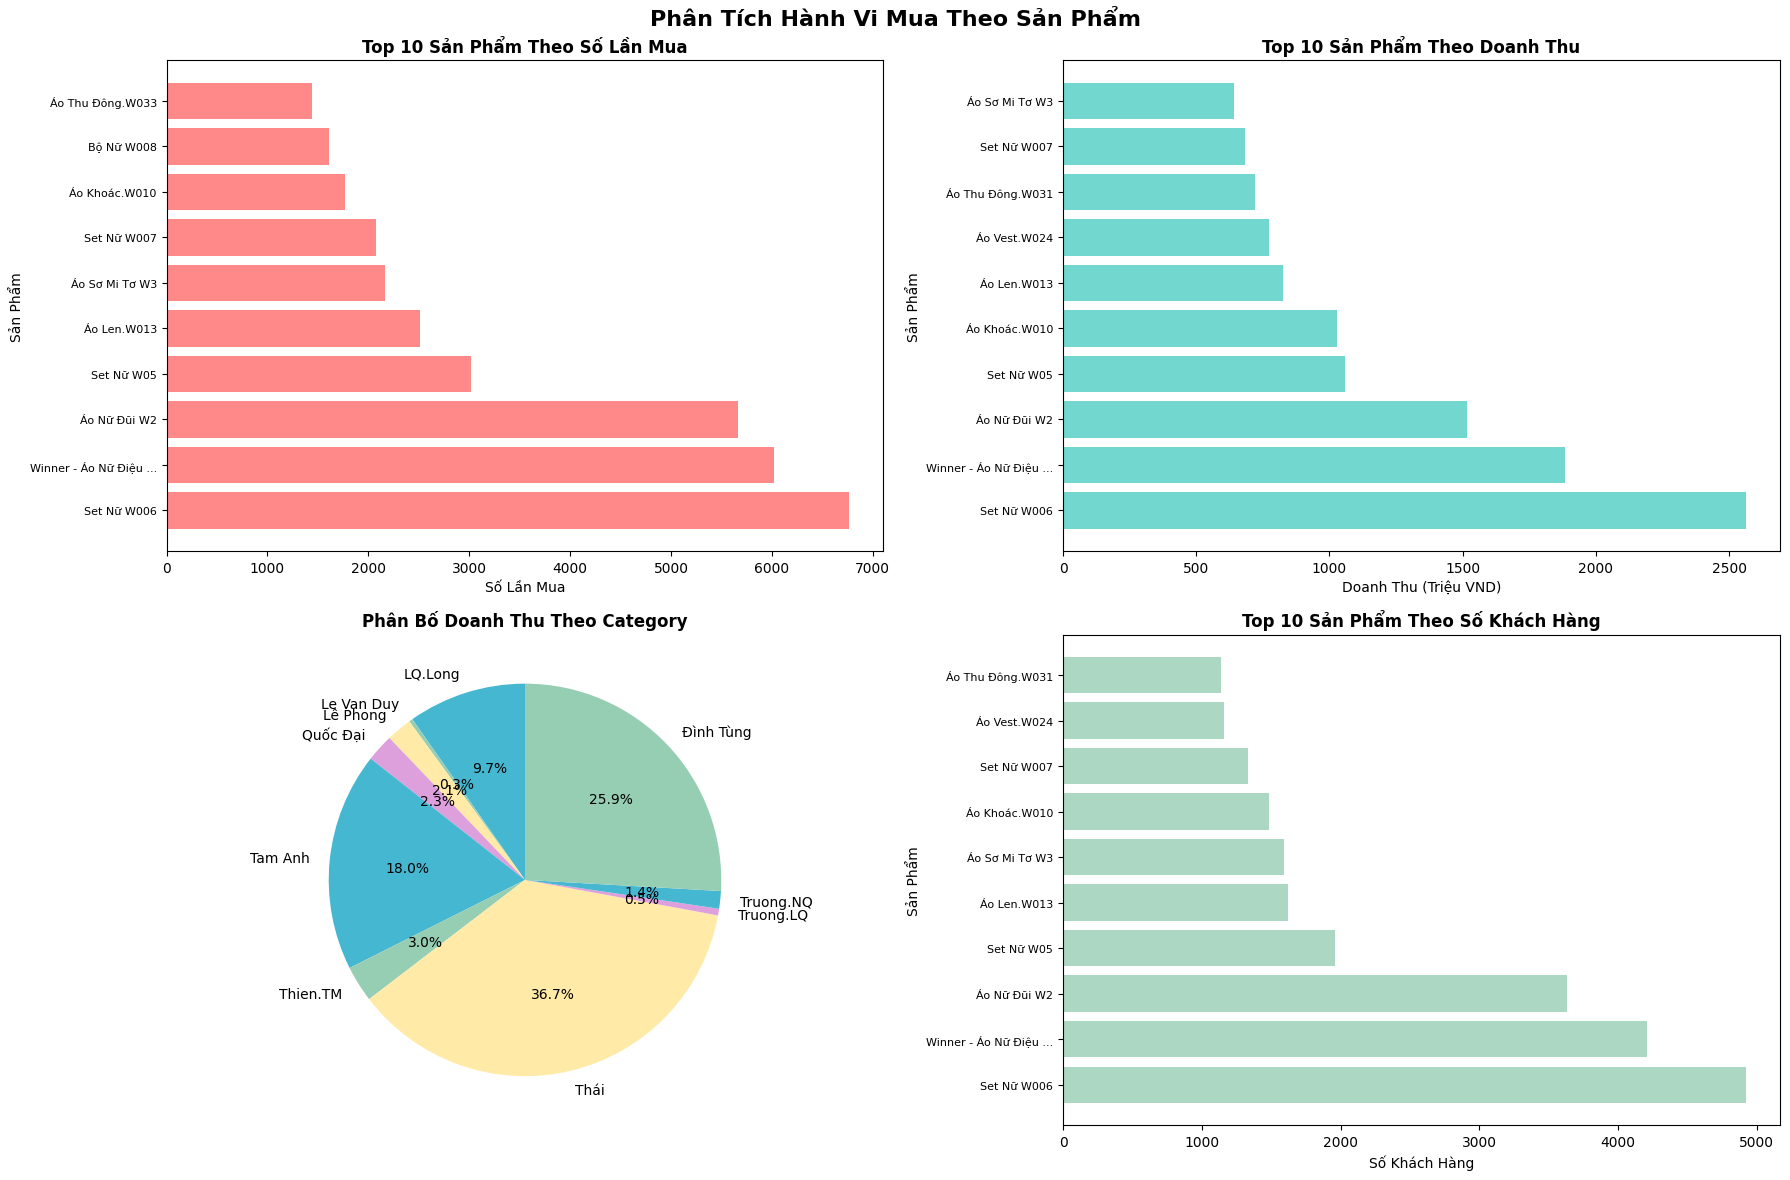

In [26]:
# Biểu đồ phân tích sản phẩm
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Phân Tích Hành Vi Mua Theo Sản Phẩm', fontsize=16, fontweight='bold', y=0.98)

# 1. Top 10 sản phẩm theo số lần mua
top_10_purchased = product_analysis.nlargest(10, 'times_purchased')
axes[0,0].barh(range(len(top_10_purchased)), top_10_purchased['times_purchased'], 
               color='#FF6B6B', alpha=0.8)
axes[0,0].set_title('Top 10 Sản Phẩm Theo Số Lần Mua', fontweight='bold')
axes[0,0].set_ylabel('Sản Phẩm')
axes[0,0].set_xlabel('Số Lần Mua')
axes[0,0].set_yticks(range(len(top_10_purchased)))
axes[0,0].set_yticklabels([name[:20] + '...' if len(name) > 20 else name for name in top_10_purchased['product_name']], fontsize=8)

# 2. Top 10 sản phẩm theo doanh thu
top_10_revenue = product_analysis.nlargest(10, 'total_revenue')
axes[0,1].barh(range(len(top_10_revenue)), top_10_revenue['total_revenue']/1000000, 
               color='#4ECDC4', alpha=0.8)
axes[0,1].set_title('Top 10 Sản Phẩm Theo Doanh Thu', fontweight='bold')
axes[0,1].set_ylabel('Sản Phẩm')
axes[0,1].set_xlabel('Doanh Thu (Triệu VND)')
axes[0,1].set_yticks(range(len(top_10_revenue)))
axes[0,1].set_yticklabels([name[:20] + '...' if len(name) > 20 else name for name in top_10_revenue['product_name']], fontsize=8)

# 3. Phân bố theo category
axes[1,0].pie(category_analysis['total_revenue'], labels=category_analysis['category'], 
              autopct='%1.1f%%', startangle=90, colors=['#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD'])
axes[1,0].set_title('Phân Bố Doanh Thu Theo Category', fontweight='bold')

# 4. Top 10 sản phẩm theo số khách hàng
top_10_customers = product_analysis.nlargest(10, 'unique_customers')
axes[1,1].barh(range(len(top_10_customers)), top_10_customers['unique_customers'], 
               color='#96CEB4', alpha=0.8)
axes[1,1].set_title('Top 10 Sản Phẩm Theo Số Khách Hàng', fontweight='bold')
axes[1,1].set_ylabel('Sản Phẩm')
axes[1,1].set_xlabel('Số Khách Hàng')
axes[1,1].set_yticks(range(len(top_10_customers)))
axes[1,1].set_yticklabels([name[:20] + '...' if len(name) > 20 else name for name in top_10_customers['product_name']], fontsize=8)

plt.tight_layout()
plt.show()

#### 2. Phân tích địa lý (Geographic Analysis)

In [30]:
DB_BRONZE = os.getenv("DB_BRONZE")
# Tạo kết nối tới bronze database
bronze_engine = create_engine(f"mysql+pymysql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_BRONZE}")

df_province = pd.read_sql_table("province_raw", bronze_engine)

In [31]:
df_province.head(2)

,province_id,province_name
0,805,An Giang
1,221,Bắc Giang


##### 2.1. Phân bố khách hàng và doanh thu theo tỉnh

In [34]:
# Phân tích phân bố khách hàng theo tỉnh
def analyze_customer_distribution_by_province():
    """
    Phân tích phân bố khách hàng theo tỉnh dựa trên:
    - Số lượng khách hàng theo tỉnh
    - Doanh thu theo tỉnh
    - Số lượng đơn hàng theo tỉnh
    - Giá trị trung bình mỗi khách hàng theo tỉnh
    """
    
    # Merge customers với orders để có thông tin đầy đủ
    customers_with_orders = df_customers.merge(df_orders, on='customer_id', how='left')
    
    # Merge với df_province để có tên tỉnh
    customers_with_province = customers_with_orders.merge(df_province, left_on='address_province_id', right_on='province_id', how='left')
    
    # Phân tích theo tỉnh
    province_analysis = customers_with_province.groupby(['address_province_id', 'province_name']).agg({
        'customer_id': 'nunique',              # Số khách hàng unique
        'order_id': 'count',                   # Số đơn hàng
        'total_price': 'sum',                  # Tổng doanh thu
        'purchased_amount': 'sum'              # Tổng giá trị mua từ customer table
    }).reset_index()
    
    # Đổi tên cột
    province_analysis.columns = ['province_id', 'province_name', 'total_customers', 'total_orders', 'total_revenue', 'total_purchased_amount']
    
    # Tính các metrics
    province_analysis['avg_revenue_per_customer'] = province_analysis['total_revenue'] / province_analysis['total_customers']
    province_analysis['avg_orders_per_customer'] = province_analysis['total_orders'] / province_analysis['total_customers']
    province_analysis['avg_order_value'] = province_analysis['total_revenue'] / province_analysis['total_orders']
    
    # Sắp xếp theo số khách hàng
    province_analysis = province_analysis.sort_values('total_customers', ascending=False)
    
    return province_analysis

# Chạy phân tích
province_analysis = analyze_customer_distribution_by_province()
print("=== PHÂN TÍCH PHÂN BỐ KHÁCH HÀNG THEO TỈNH ===")
print(f"Phân tích {len(province_analysis)} tỉnh/thành phố")
print(f"Tổng số khách hàng: {province_analysis['total_customers'].sum():,}")
print(f"Tổng doanh thu: {province_analysis['total_revenue'].sum():,.0f} VND")
print("-" * 80)
province_analysis.head(10)


=== PHÂN TÍCH PHÂN BỐ KHÁCH HÀNG THEO TỈNH ===
Phân tích 63 tỉnh/thành phố
Tổng số khách hàng: 32,449
Tổng doanh thu: 17,873,412,900 VND
--------------------------------------------------------------------------------


,province_id,province_name,total_customers,total_orders,total_revenue,total_purchased_amount,avg_revenue_per_customer,avg_orders_per_customer,avg_order_value
0,101,Hà Nội,6069,6926,3.666858e+09,2.064522e+09,604194.743780,1.141209,529433.713543
42,701,Hồ Chí Minh,2376,2621,1.296038e+09,7.995541e+08,545470.538721,1.103114,494482.258680
1,103,Hải Phòng,1442,1620,8.670560e+08,4.577350e+08,601287.101248,1.123440,535219.753086
20,225,Quảng Ninh,1105,1243,6.400760e+08,3.170250e+08,579254.298643,1.124887,514944.489139
25,401,Thanh Hóa,1073,1193,5.847070e+08,2.743830e+08,544927.306617,1.111836,490114.836547
26,403,Nghệ An,1007,1133,5.325840e+08,2.500410e+08,528881.827210,1.125124,470065.313327
47,713,Đồng Nai,819,886,4.235970e+08,2.342670e+08,517212.454212,1.081807,478100.451467
3,106,Bắc Ninh,708,786,3.927950e+08,1.842360e+08,554795.197740,1.110169,499739.185751
19,221,Bắc Giang,686,753,3.608640e+08,1.571900e+08,526040.816327,1.097668,479235.059761
4,107,Hải Dương,628,704,3.428270e+08,1.571480e+08,545902.866242,1.121019,486970.170455


In [35]:
# Hiển thị kết quả chi tiết theo các chỉ số
print("=== RANKING TỈNH/THÀNH PHỐ THEO CÁC CHỈ SỐ ===")
print()

# 1. Top tỉnh theo số khách hàng
print("TOP TỈNH THEO SỐ KHÁCH HÀNG:")
top_customers_province = province_analysis.nlargest(15, 'total_customers')[['province_name', 'total_customers', 'total_revenue', 'avg_revenue_per_customer']]
for idx, row in top_customers_province.iterrows():
    print(f"   {row['province_name']}: {row['total_customers']:,} khách hàng ({row['total_revenue']:,.0f} VND) - AOV: {row['avg_revenue_per_customer']:,.0f} VND")

print()

# 2. Top tỉnh theo doanh thu
print("TOP TỈNH THEO DOANH THU:")
top_revenue_province = province_analysis.nlargest(15, 'total_revenue')[['province_name', 'total_revenue', 'total_customers', 'avg_revenue_per_customer']]
for idx, row in top_revenue_province.iterrows():
    print(f"   {row['province_name']}: {row['total_revenue']:,.0f} VND ({row['total_customers']:,} khách hàng) - AOV: {row['avg_revenue_per_customer']:,.0f} VND")

print()

# 3. Top tỉnh theo giá trị trung bình mỗi khách hàng
print("TOP TỈNH THEO GIÁ TRỊ TRUNG BÌNH MỖI KHÁCH HÀNG:")
top_avg_province = province_analysis.nlargest(15, 'avg_revenue_per_customer')[['province_name', 'avg_revenue_per_customer', 'total_customers', 'total_revenue']]
for idx, row in top_avg_province.iterrows():
    print(f"   {row['province_name']}: {row['avg_revenue_per_customer']:,.0f} VND/khách ({row['total_customers']:,} khách hàng) - Tổng: {row['total_revenue']:,.0f} VND")

print()

# 4. Thống kê tổng quan
print("=== THỐNG KÊ TỔNG QUAN ===")
print(f"   Tổng số tỉnh/thành phố có khách hàng: {len(province_analysis)}")
print(f"   Tỉnh có nhiều khách hàng nhất: {province_analysis.iloc[0]['province_name']} ({province_analysis.iloc[0]['total_customers']:,} khách hàng)")
print(f"   Tỉnh có doanh thu cao nhất: {top_revenue_province.iloc[0]['province_name']} ({top_revenue_province.iloc[0]['total_revenue']:,.0f} VND)")
print(f"   Tỉnh có giá trị khách hàng cao nhất: {top_avg_province.iloc[0]['province_name']} ({top_avg_province.iloc[0]['avg_revenue_per_customer']:,.0f} VND/khách)")
print(f"   Giá trị trung bình mỗi khách hàng: {province_analysis['avg_revenue_per_customer'].mean():,.0f} VND")
print(f"   Số đơn hàng trung bình mỗi khách hàng: {province_analysis['avg_orders_per_customer'].mean():.2f} đơn")


=== RANKING TỈNH/THÀNH PHỐ THEO CÁC CHỈ SỐ ===

TOP TỈNH THEO SỐ KHÁCH HÀNG:
   Hà Nội: 6,069 khách hàng (3,666,857,900 VND) - AOV: 604,195 VND
   Hồ Chí Minh: 2,376 khách hàng (1,296,038,000 VND) - AOV: 545,471 VND
   Hải Phòng: 1,442 khách hàng (867,056,000 VND) - AOV: 601,287 VND
   Quảng Ninh: 1,105 khách hàng (640,076,000 VND) - AOV: 579,254 VND
   Thanh Hóa: 1,073 khách hàng (584,707,000 VND) - AOV: 544,927 VND
   Nghệ An: 1,007 khách hàng (532,584,000 VND) - AOV: 528,882 VND
   Đồng Nai: 819 khách hàng (423,597,000 VND) - AOV: 517,212 VND
   Bắc Ninh: 708 khách hàng (392,795,000 VND) - AOV: 554,795 VND
   Bắc Giang: 686 khách hàng (360,864,000 VND) - AOV: 526,041 VND
   Hải Dương: 628 khách hàng (342,827,000 VND) - AOV: 545,903 VND
   Bình Dương: 625 khách hàng (319,870,000 VND) - AOV: 511,792 VND
   Đắk Lắk: 590 khách hàng (325,344,000 VND) - AOV: 551,431 VND
   Thái Nguyên: 515 khách hàng (269,672,000 VND) - AOV: 523,635 VND
   Tây Ninh: 508 khách hàng (268,267,000 VND) - AOV:

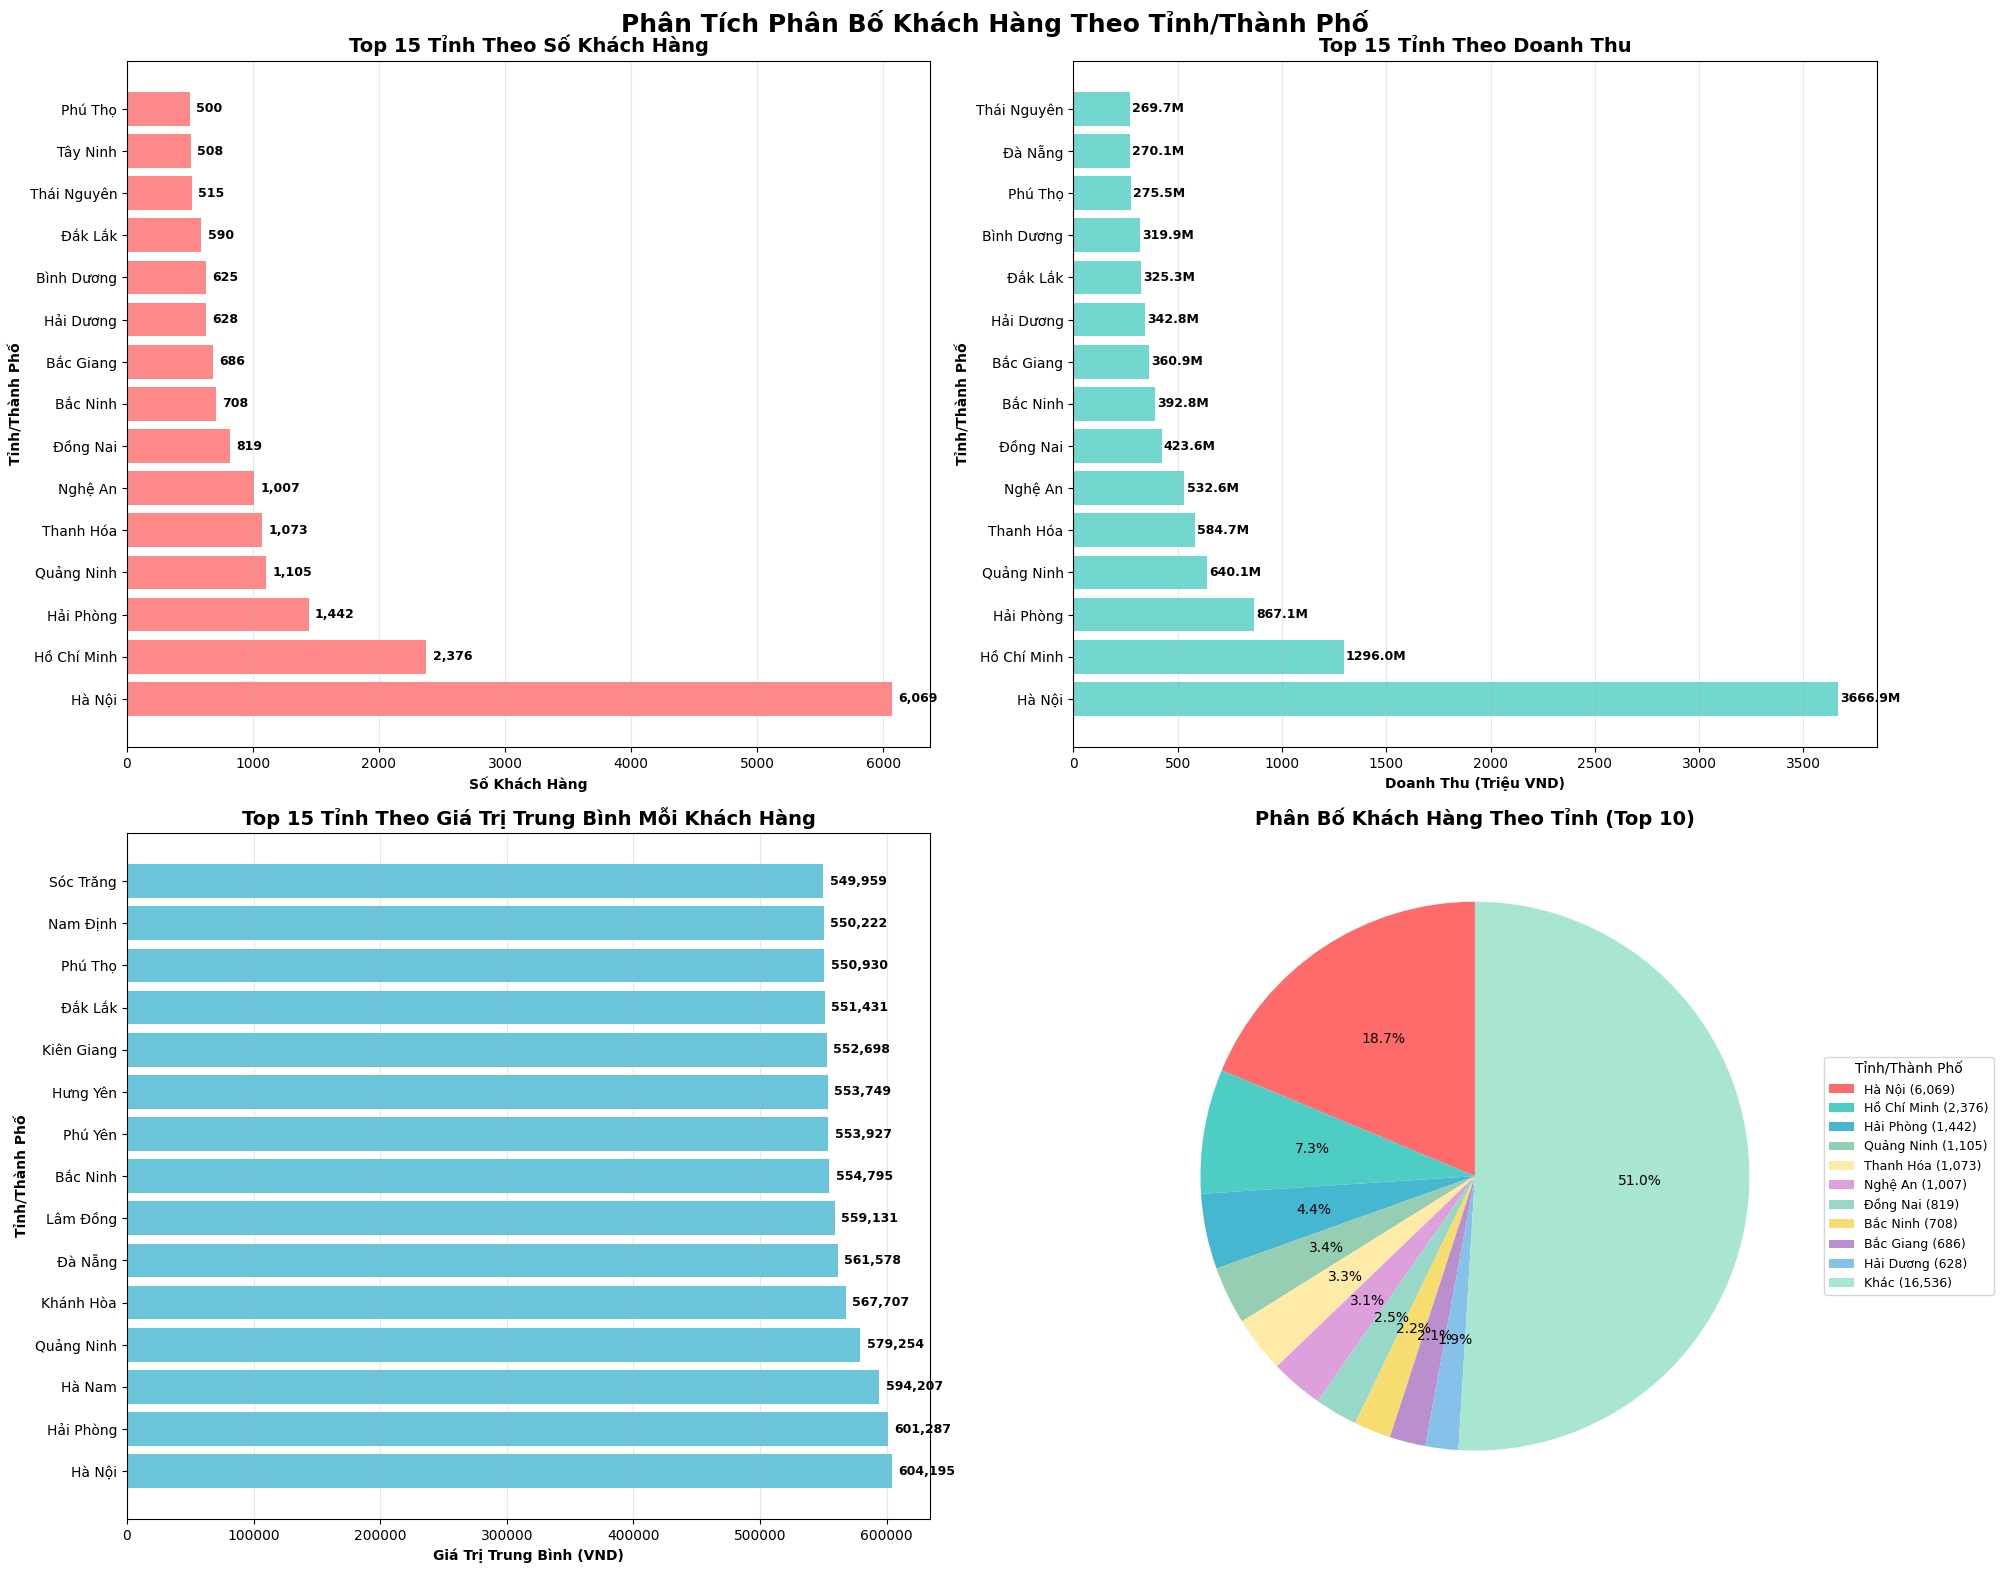

In [37]:
# Tạo biểu đồ trực quan hóa phân bố khách hàng theo tỉnh
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Phân Tích Phân Bố Khách Hàng Theo Tỉnh/Thành Phố', fontsize=18, fontweight='bold', y=0.98)

# Lấy top 15 tỉnh để hiển thị rõ ràng
top_15_customers = province_analysis.head(15)

# 1. Biểu đồ cột - Số khách hàng theo tỉnh
axes[0,0].barh(range(len(top_15_customers)), top_15_customers['total_customers'], 
               color='#FF6B6B', alpha=0.8)
axes[0,0].set_title('Top 15 Tỉnh Theo Số Khách Hàng', fontweight='bold', fontsize=14)
axes[0,0].set_xlabel('Số Khách Hàng', fontweight='bold')
axes[0,0].set_ylabel('Tỉnh/Thành Phố', fontweight='bold')
axes[0,0].set_yticks(range(len(top_15_customers)))
axes[0,0].set_yticklabels(top_15_customers['province_name'], fontsize=10)
axes[0,0].grid(axis='x', alpha=0.3)

# Thêm giá trị trên mỗi bar
for i, v in enumerate(top_15_customers['total_customers']):
    axes[0,0].text(v + 50, i, f'{v:,}', va='center', fontweight='bold', fontsize=9)

# 2. Biểu đồ cột - Doanh thu theo tỉnh
top_15_revenue = province_analysis.nlargest(15, 'total_revenue')
axes[0,1].barh(range(len(top_15_revenue)), top_15_revenue['total_revenue']/1000000, 
               color='#4ECDC4', alpha=0.8)
axes[0,1].set_title('Top 15 Tỉnh Theo Doanh Thu', fontweight='bold', fontsize=14)
axes[0,1].set_xlabel('Doanh Thu (Triệu VND)', fontweight='bold')
axes[0,1].set_ylabel('Tỉnh/Thành Phố', fontweight='bold')
axes[0,1].set_yticks(range(len(top_15_revenue)))
axes[0,1].set_yticklabels(top_15_revenue['province_name'], fontsize=10)
axes[0,1].grid(axis='x', alpha=0.3)

# Thêm giá trị trên mỗi bar
for i, v in enumerate(top_15_revenue['total_revenue']/1000000):
    axes[0,1].text(v + 10, i, f'{v:.1f}M', va='center', fontweight='bold', fontsize=9)

# 3. Biểu đồ cột - Giá trị trung bình mỗi khách hàng
top_15_avg = province_analysis.nlargest(15, 'avg_revenue_per_customer')
axes[1,0].barh(range(len(top_15_avg)), top_15_avg['avg_revenue_per_customer'], 
               color='#45B7D1', alpha=0.8)
axes[1,0].set_title('Top 15 Tỉnh Theo Giá Trị Trung Bình Mỗi Khách Hàng', fontweight='bold', fontsize=14)
axes[1,0].set_xlabel('Giá Trị Trung Bình (VND)', fontweight='bold')
axes[1,0].set_ylabel('Tỉnh/Thành Phố', fontweight='bold')
axes[1,0].set_yticks(range(len(top_15_avg)))
axes[1,0].set_yticklabels(top_15_avg['province_name'], fontsize=10)
axes[1,0].grid(axis='x', alpha=0.3)

# Thêm giá trị trên mỗi bar
for i, v in enumerate(top_15_avg['avg_revenue_per_customer']):
    axes[1,0].text(v + 5000, i, f'{v:,.0f}', va='center', fontweight='bold', fontsize=9)

# 4. Biểu đồ tròn - Phân bố khách hàng theo tỉnh (top 10)
top_10_customers = province_analysis.head(10)
other_customers = province_analysis.iloc[10:]['total_customers'].sum()

# Tạo dữ liệu cho biểu đồ tròn
pie_data = list(top_10_customers['total_customers']) + [other_customers]
pie_labels = list(top_10_customers['province_name']) + ['Khác']

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', 
          '#DDA0DD', '#98D8C8', '#F7DC6F', '#BB8FCE', '#85C1E9', '#A8E6CF']

wedges, texts, autotexts = axes[1,1].pie(pie_data, labels=None, autopct='%1.1f%%', 
                                         colors=colors, startangle=90)
axes[1,1].set_title('Phân Bố Khách Hàng Theo Tỉnh (Top 10)', fontweight='bold', fontsize=14)

# Tạo legend
axes[1,1].legend(wedges, [f'{label} ({count:,})' for label, count in zip(pie_labels, pie_data)],
                title="Tỉnh/Thành Phố",
                loc="center left",
                bbox_to_anchor=(1, 0, 0.5, 1),
                fontsize=9)

plt.tight_layout()
plt.show()


##### 2.2. Phân tích chi phí vận chuyển

In [ ]:
def shipping_cost_overview():
    # Bảo toàn dữ liệu gốc
    orders = df_orders.copy()

    # Chuẩn hóa kiểu số cho shipping_fee
    orders['shipping_fee'] = pd.to_numeric(orders['shipping_fee'], errors='coerce').fillna(0)
    orders['total_price'] = pd.to_numeric(orders['total_price'], errors='coerce').fillna(0)

    # Tính các chỉ số tổng quan
    n_orders = len(orders)
    total_shipping_fee = orders['shipping_fee'].sum()
    avg_shipping_fee = orders['shipping_fee'].mean()
    median_shipping_fee = orders['shipping_fee'].median()
    pct_free_shipping = (orders['is_free_shipping'].astype(int).mean() * 100.0)

    # Tỷ lệ phí ship/doanh thu
    total_revenue = orders['total_price'].sum()
    shipping_to_revenue_ratio = total_shipping_fee / total_revenue if total_revenue > 0 else 0

    # In kết quả
    print("=== SHIPPING COST OVERVIEW ===")
    print(f"Số đơn hàng: {n_orders:,}")
    print(f"Tổng phí ship: {total_shipping_fee:,.0f} VND")
    print(f"Phí ship trung bình/đơn: {avg_shipping_fee:,.0f} VND  | Median: {median_shipping_fee:,.0f} VND")
    print(f"Tỷ lệ Free Shipping: {pct_free_shipping:.1f}%")
    print(f"Tỷ lệ phí ship/doanh thu: {shipping_to_revenue_ratio:.2%}")

    return orders

orders_for_shipping = shipping_cost_overview()

=== SHIPPING COST OVERVIEW ===
Số đơn hàng: 40,236
Tổng phí ship: 257,012,140 VND
Phí ship trung bình/đơn: 6,388 VND  | Median: 0 VND
Tỷ lệ Free Shipping: 0.1%
Tỷ lệ phí ship/doanh thu: 1.44%
--------------------------------------------------------------------------------


In [44]:
def shipping_cost_by_province():
    # Merge orders với shipping để lấy tỉnh giao hàng
    ow = orders_for_shipping.merge(df_shipping, on='shipping_id', how='left')

    # Merge tên tỉnh
    ow = ow.merge(df_province, left_on='shipping_province_id', right_on='province_id', how='left')

    # Tính các chỉ số theo tỉnh
    grp = ow.groupby(['shipping_province_id', 'province_name'], dropna=False).agg({
        'order_id': 'nunique',
        'customer_id': 'nunique',
        'shipping_fee': 'sum',
        'total_price': 'sum'
    }).reset_index()

    grp.columns = ['province_id', 'province_name', 'total_orders', 'unique_customers',
                   'total_shipping_fee', 'total_revenue']

    grp['avg_shipping_fee_per_order'] = grp['total_shipping_fee'] / grp['total_orders'].replace(0, np.nan)
    grp['shipping_to_revenue_ratio'] = grp['total_shipping_fee'] / grp['total_revenue'].replace(0, np.nan)

    # Sắp xếp theo tổng phí ship
    grp = grp.sort_values('total_shipping_fee', ascending=False)

    print("=== SHIPPING COST BY PROVINCE (TOP 15 BY TOTAL SHIPPING FEE) ===")
    display(grp.head(15))
    return grp

shipping_by_province = shipping_cost_by_province()

=== SHIPPING COST BY PROVINCE (TOP 15 BY TOTAL SHIPPING FEE) ===


,province_id,province_name,total_orders,unique_customers,total_shipping_fee,total_revenue,avg_shipping_fee_per_order,shipping_to_revenue_ratio
0,101,Hà Nội,6803,6080,57295920.0,3.663114e+09,8422.154932,0.015641
42,701,Hồ Chí Minh,2591,2382,17982100.0,1.296795e+09,6940.216133,0.013867
1,103,Hải Phòng,1603,1443,14563000.0,8.673750e+08,9084.840923,0.016790
20,225,Quảng Ninh,1219,1105,10914000.0,6.400760e+08,8953.240361,0.017051
25,401,Thanh Hóa,1172,1075,8930100.0,5.847070e+08,7619.539249,0.015273
26,403,Nghệ An,1104,1009,7961000.0,5.332130e+08,7211.050725,0.014930
3,106,Bắc Ninh,767,709,6070000.0,3.927950e+08,7913.950456,0.015453
4,107,Hải Dương,691,630,5620000.0,3.443840e+08,8133.140376,0.016319
39,605,Đắk Lắk,640,590,4890000.0,3.253440e+08,7640.625000,0.015030
19,221,Bắc Giang,738,686,4872000.0,3.602150e+08,6601.626016,0.013525


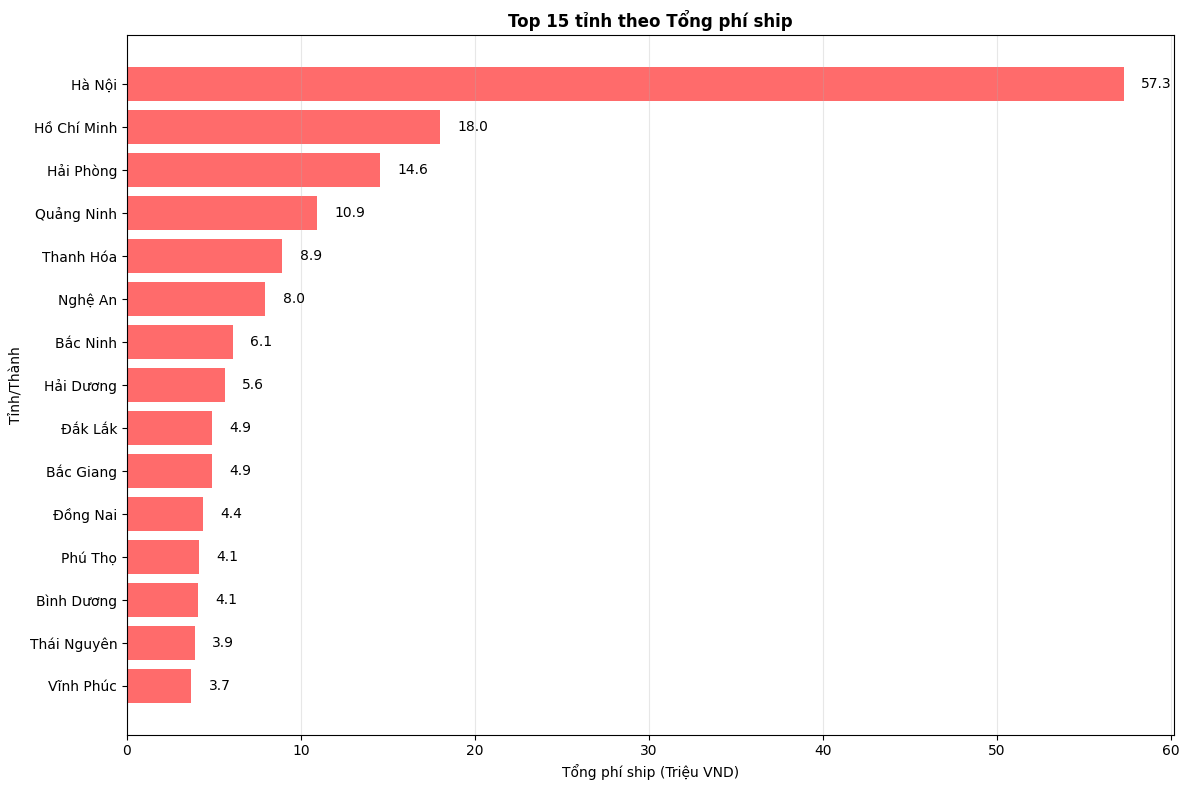

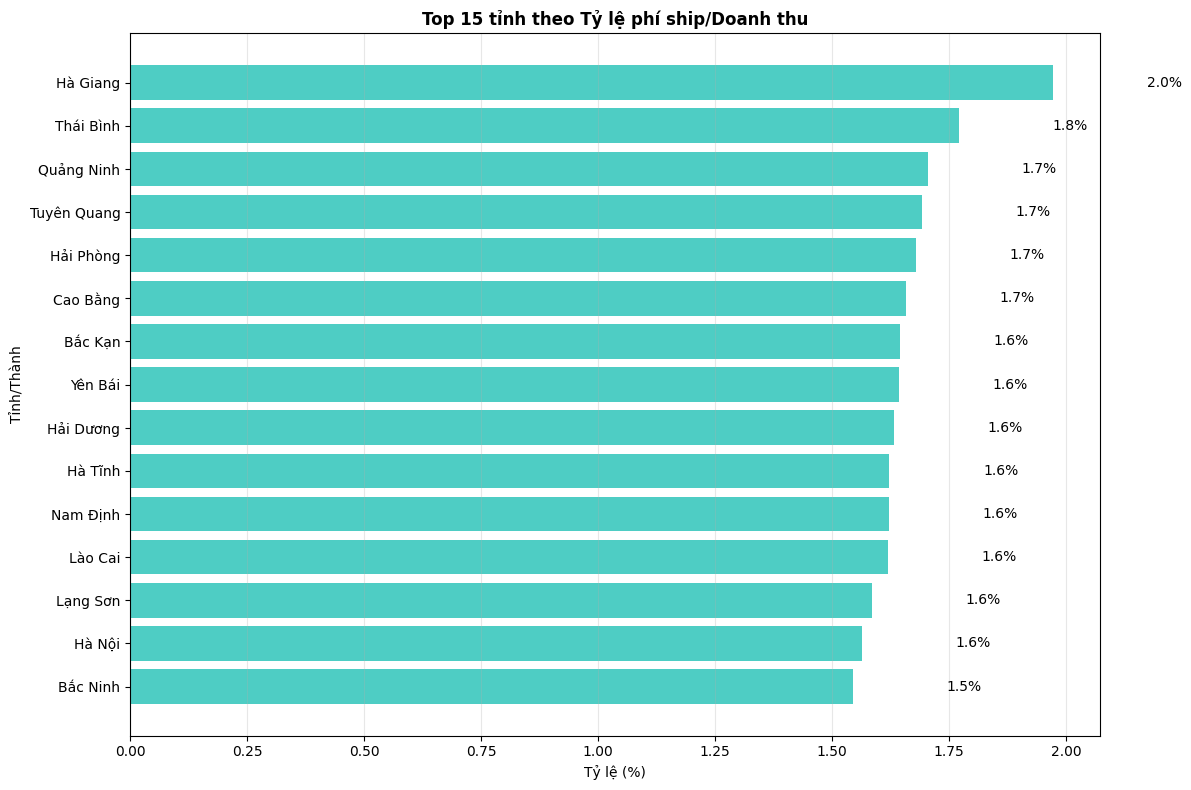

In [47]:
# 4.2 Top 15 tỉnh theo tổng phí ship
top_ship = shipping_by_province.nlargest(15, 'total_shipping_fee')
plt.figure(figsize=(12,8))
plt.barh(top_ship['province_name'].fillna('Unknown'), top_ship['total_shipping_fee']/1e6, color='#FF6B6B')
plt.title('Top 15 tỉnh theo Tổng phí ship', fontweight='bold')
plt.xlabel('Tổng phí ship (Triệu VND)'); plt.ylabel('Tỉnh/Thành')
for i, v in enumerate(top_ship['total_shipping_fee']/1e6):
    plt.text(v+1, i, f'{v:.1f}', va='center')
plt.gca().invert_yaxis(); plt.grid(axis='x', alpha=0.3); plt.tight_layout(); plt.show()

# 4.3 Tỷ lệ phí ship/doanh thu theo tỉnh (Top 15 theo ratio)
ratio_top = shipping_by_province.dropna(subset=['shipping_to_revenue_ratio']).nlargest(15, 'shipping_to_revenue_ratio')
plt.figure(figsize=(12,8))
plt.barh(ratio_top['province_name'].fillna('Unknown'), ratio_top['shipping_to_revenue_ratio']*100, color='#4ECDC4')
plt.title('Top 15 tỉnh theo Tỷ lệ phí ship/Doanh thu', fontweight='bold')
plt.xlabel('Tỷ lệ (%)'); plt.ylabel('Tỉnh/Thành')
for i, v in enumerate(ratio_top['shipping_to_revenue_ratio']*100):
    plt.text(v+0.2, i, f'{v:.1f}%', va='center')
plt.gca().invert_yaxis(); plt.grid(axis='x', alpha=0.3); plt.tight_layout(); plt.show()